## Aircraft wildlife strike data analysis

### **Context**

Wildlife strikes have posed a significant threat to the aviation industry since its inception. Though wildlife may seem rather harmless due to their small size relative to that of aircrafts, Newton's laws of physics state that depending on the aircraft's size and the airspeed during impact, these collisions can be highly devastating. Notable wildlife strike incidents in aviation history include the emergency landing of US Airways Flight 1549 (Sully), where the Airbus A320 suffered double engine failure after striking a flock of birds (fortunately, there were no fatalities), and the more recent tragic Jeju Air crash, where 179 passengers lost their lives following a similar incident.

Given the potential for severe damage to aircrafts, understanding the factors contributing to cost of repair and maintenance is crucial for the aviation industry. Thus, this project aims to build a model that predicts the cost of repairs and/or replacement in USD, which can be very helpful for companies to develop strategies to mitigate these costs. To accurately understand the costs associated with repairs and maintenance, wildlife strike data was obtained from the Federal Aviation Administration, which spans from 1990 to 2024.

Link to data: https://wildlife.faa.gov/search

#### Loading all the necessary libraries

In [3]:
!pip install catboost
!pip install causalml
!pip install dowhy

import datetime
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, r2_score
from sklearn.model_selection import RandomizedSearchCV

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from causalml.inference.meta import LRSRegressor, XGBTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from sklearn.inspection import permutation_importance
from causalml.dataset.regression import *
from causalml.metrics import *
from dowhy import CausalModel
import dowhy.datasets
import shap

import time
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

#### Loading the data

In [2]:
cols_to_keep = ['INCIDENT_MONTH', 'TIME','TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'AIRCRAFT', 'EMA', 'AC_CLASS', 'AC_MASS', 'TYPE_ENG', 'NUM_ENGS', 'SPEED', 'PHASE_OF_FLIGHT', 'DAMAGE_LEVEL', 'DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_ENG1', 'ING_ENG1', 'DAM_ENG2', 'ING_ENG2', 'DAM_ENG3', 'ING_ENG3', 'DAM_ENG4', 'ING_ENG4', 'INGESTED_OTHER', 'DAM_PROP', 'DAM_WING_ROT', 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER', 'NUM_STRUCK', 'SIZE', 'COST_REPAIRS_INFL_ADJ']

def load_data(keep_cols=None):
    """
    Load data from a specified Excel file.
    Args:
        keep_cols (list, optional): List of column names to keep from the loaded DataFrame.
    Returns:
        pd.DataFrame: The loaded DataFrame or None if an error occurs.
    """
    file_path = input("Enter the path to your Excel file: ")  # Prompt for file path
    try:
        data = pd.read_excel(file_path)
        print("Data successfully loaded.")
        if keep_cols:
            data = data[keep_cols]
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data(keep_cols=cols_to_keep)
df_copy = df.copy()

Enter the path to your Excel file: /content/Strike_Reports.xlsx
Data successfully loaded.


Variables considered:
1. Time/time of day
- Time of day affects availability of resources, severity of strike, airport operations, and may also coincide with specific weather conditions, which affect repair needs.
2. Aircraft/ aircraft type & mass
- Laws of physics state that the higher the mass of an object, the greater the impact on collision with another object/ living thing. This has a direct implication of the extent of damage on the aircraft, and the cost of repair.
3. Size & number of wildlife struck
- Both factors combined directly impacts the level of damage and costs of repair. A small wildlife by itself might not be as significiant as a small wildlife in flock.
4. Speed of aircraft
- Laws of physics. Larger the momentum, greater the impact, and thus repair. At the same phase of flight, airplanes are most likely to have similar speeds. Thus, missing speed values will be imputed using the corresponding median speeds for each phase of flight.
5. Damage & costs to aircraft
- Damages are the reason for cost and thus most definitely need to be retained for analysis.
6. Type of engine
- Engine repairs typically take up the bulk of repair costs. Thus, it is essential to retain this variable as it can affect how expensive the repairs might be.
7. Airport location
- Affects the species of birds (and therefore their size) in the vicinity and their migration patterns, which affects the strikes and therefore cost of repairs.

#### Inspect data

In [4]:
df_copy.head()

,INCIDENT_MONTH,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,AIRCRAFT,EMA,AC_CLASS,AC_MASS,TYPE_ENG,NUM_ENGS,SPEED,PHASE_OF_FLIGHT,DAMAGE_LEVEL,DAM_RAD,DAM_WINDSHLD,DAM_NOSE,DAM_ENG1,ING_ENG1,DAM_ENG2,ING_ENG2,DAM_ENG3,ING_ENG3,DAM_ENG4,ING_ENG4,INGESTED_OTHER,DAM_PROP,DAM_WING_ROT,DAM_FUSE,DAM_LG,DAM_TAIL,DAM_LGHTS,DAM_OTHER,NUM_STRUCK,SIZE,COST_REPAIRS_INFL_ADJ
0,9,19:50,Dusk,KORD,41.97960,-87.90446,B-777-300,22.0,A,5.0,D,2.0,NaN,Take-off Run,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2-10,Small,365000.0
1,3,NaN,Day,KCVG,39.04614,-84.66217,B-737-800,10.0,A,4.0,D,2.0,155.0,Approach,N,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,11-100,Small,71000.0
2,7,19:15,Day,KAUS,30.19453,-97.66987,B-737-8,10.0,A,4.0,D,2.0,140.0,Landing Roll,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2-10,Small,1000.0
3,9,21:30,Night,KUNV,40.84928,-77.84869,EMB-170,22.0,A,4.0,D,2.0,NaN,Approach,N,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,Small,630.0
4,7,NaN,NaN,KLGA,40.77724,-73.87261,A-320,23.0,A,4.0,D,2.0,NaN,Climb,M,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,1,Medium,NaN


#### Cleaning the data

In [5]:
def process_time_of_day(data, time_col='TIME', month_col='INCIDENT_MONTH'):
    """
    Process the time of day based on the time and incident month, and clean the dataset.
    Args:
        data (pd.DataFrame): The input DataFrame.
        time_col (str): The column name for time (format '%H:%M').
        month_col (str): The column name for incident month.
    Returns:
        pd.DataFrame: The processed DataFrame with a new 'TIME_OF_DAY' column and cleaned data.
    """
    def assign_time_of_day(row):
        time = row[time_col]
        month = row[month_col]
        # Check if TIME is missing or invalid
        if pd.isna(time):
            return None  # Skip if TIME is missing
        # Convert TIME to datetime if not already
        time = str(time).strip()
        try:
            time = pd.to_datetime(time, errors='raise').time()
        except Exception:
            return None  # Return None for invalid time formats

        # Define time ranges for different seasons
        seasons = {
            'summer': [5, 6, 7, 8],    # Summer months
            'winter': [11, 12, 1, 2],  # Winter months
            'transitional': [3, 4, 9, 10]  # Transitional months
        }

        # Determine the season based on the month
        season = 'transitional'  # Default season is transitional
        for s, months in seasons.items():
            if month in months:
                season = s
                break

        # Define time-of-day ranges for each season
        time_ranges = {
            'summer': {
                'Dawn': (datetime.time(4, 0), datetime.time(6, 0)),
                'Day': (datetime.time(6, 0), datetime.time(20, 0)),
                'Dusk': (datetime.time(20, 0), datetime.time(21, 30)),
                'Night': (datetime.time(21, 30), datetime.time(4, 0))
            },
            'winter': {
                'Dawn': (datetime.time(6, 0), datetime.time(7, 30)),
                'Day': (datetime.time(7, 30), datetime.time(17, 30)),
                'Dusk': (datetime.time(17, 30), datetime.time(18, 30)),
                'Night': (datetime.time(18, 30), datetime.time(6, 0))
            },
            'transitional': {
                'Dawn': (datetime.time(5, 0), datetime.time(7, 0)),
                'Day': (datetime.time(7, 0), datetime.time(19, 0)),
                'Dusk': (datetime.time(19, 0), datetime.time(20, 30)),
                'Night': (datetime.time(20, 30), datetime.time(5, 0))
            }
        }

        # Identify the time of day based on the season and time range
        for period, (start_time, end_time) in time_ranges[season].items():
            if start_time <= time < end_time:
                return period
        return 'Night'  # Default to 'Night' if no match

    # Apply the function to assign time of day
    data['TIME_OF_DAY'] = data.apply(assign_time_of_day, axis=1)

    # Drop rows where 'TIME_OF_DAY' couldn't be assigned but 'time_col' is not missing
    missing_time_of_day = data[data['TIME_OF_DAY'].isna() & data[time_col].notna()]
    print(f'Number of entries without "TIME_OF_DAY" filled in: {missing_time_of_day.shape[0]}')

    # Drop the 'time_col' column and rows without 'TIME_OF_DAY'
    data = data.drop(columns=[time_col])
    data = data.dropna(subset=['TIME_OF_DAY'])

    return data

In [6]:
def aircraft_mass(df):
    """
    Clean the dataset based on the aircraft type, aircraft name (family) and the mass
    Args:
        data (pd.DataFrame): The input DataFrame.
    """

    # Filter out rows with missing 'AC_CLASS' values
    df = df[~df['AC_CLASS'].isna()]
    # Filter for aircraft class 'A' corresponding to airplanes
    df = df[df['AC_CLASS'] == 'A']
    # Drop AC_CLASS column
    df.drop('AC_CLASS', axis=1, inplace=True)
    # Set AC_MASS to category 4 for 'AC-130' aircraft
    df.loc[df['AIRCRAFT'] == 'AC-130', 'AC_MASS'] = 4
    # Drop rows with missing AC_MASS
    df.dropna(subset=['AC_MASS'], inplace=True)
    # Map aircraft mass categories to specified ranges defined in metadata
    mass_mapping = {
        '1.0': '2250 or less',
        '2.0': '2251-5700',
        '3.0': '5701-27000',
        '4.0': '27001-272000',
        '5.0': '272001 or more'
    }
    # Convert 'AC_MASS' to string and map to mass categories
    df['AC_MASS'] = df['AC_MASS'].astype(str).map(mass_mapping)

    # Inner function to extract aircraft family using regex
    def extract_air_family(name):
        matched = re.search(r'([A-Za-z0-9]+-[A-Za-z0-9]+)', name)
        if matched:
            return matched.group(0)
        else:
            return name

    # Apply the regex to standardise the name then drop the original aircraft col
    df['AIRCRAFT_FAMILY'] = df['AIRCRAFT'].apply(extract_air_family)
    df = df.drop('AIRCRAFT', axis=1)
    # Calculate proportion of aircraft families
    prop = df['AIRCRAFT_FAMILY'].value_counts(normalize=True).sort_values(ascending=False).cumsum()
    # Filter aircrafts contributing to top 95% of total
    top_95 = prop[prop <= 0.95].index
    # Create new column to regroup aircraft families
    df['AIRCRAFT_FAMILY_GROUPED'] = df['AIRCRAFT_FAMILY'].apply(lambda x: x if x in top_95 else 'Others')
    return df

In [7]:
def bird(df):
    """
    Remove rows with missing values in 'NUM_STRUCK' AND 'SIZE' columns.
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # Drop rows with missing values in 'NUM_STRUCK' and 'SIZE' columns
    df = df[~(df['NUM_STRUCK'].isna() | df['SIZE'].isna())]
    return df

In [8]:
def phase_speed(df):
    """
    Fill in rows with missing speed values with the median speeds for aircrafts within the same phase of flight
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # Drop rows with unknown phase of flight
    df = df[df['PHASE_OF_FLIGHT'] != 'Unknown']
    # Calculate the median SPEED for each PHASE_OF_FLIGHT
    phase_medians = df.groupby('PHASE_OF_FLIGHT')['SPEED'].median()
    # Fill missing SPEED values with the corresponding median values
    df['SPEED'] = df['SPEED'].fillna(
        df['PHASE_OF_FLIGHT'].map(phase_medians)
    )
    # Drop the remaining entries with missing speed and drop phase of flight col
    df = df.dropna(subset=['SPEED'])
    df = df.drop('PHASE_OF_FLIGHT', axis=1)
    return df

In [9]:
damage_components = ['DAM_RAD', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4', 'DAM_PROP', 'DAM_WING_ROT', 'DAM_FUSE', 'DAM_LG', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_OTHER']
ingestion = ['ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4', 'INGESTED_OTHER']

def damage_cost(df):
    """
    Remove invalid costs using damage as the reference, fill in missing values for damage cols, and log transformation to cost
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # First deal with damages and the associated cost
    # Fill in damage level with N if all damage components are false
    df.loc[df[damage_components].sum(axis=1) == 0, 'DAMAGE_LEVEL'] = 'N'
    # Extract rows with all damage components = False to investigate cost col
    no_damage = df[~df[damage_components].any(axis=1)]
    # Fill 0 in rows with NA repair costs where entries correspond to those with no damage
    df['COST_REPAIRS_INFL_ADJ'] = df.apply(
        lambda row: 0 if row.name in no_damage.index and pd.isna(row['COST_REPAIRS_INFL_ADJ']) else row['COST_REPAIRS_INFL_ADJ'],
        axis=1
    )
    # Fill in 0 in cost where damage level is N if cost is na
    df.loc[
        df['COST_REPAIRS_INFL_ADJ'].isna() &
        df['DAMAGE_LEVEL'].isin(['0', 'N']),
        'COST_REPAIRS_INFL_ADJ'] = 0
    # Set up condition that defines all ingestion and damage components are False but cost > 0
    condition = (
        (df[ingestion].sum(axis=1) == 0) &
        (df[damage_components].sum(axis=1) == 0) &
        (df['COST_REPAIRS_INFL_ADJ'] > 0)
    )
    # Remove rows that satisfy the condition
    df = df[~condition]
    # Damage mapping dictionary according to metadata
    damage_map = {
        'N': 'None',
        'M': 'Minor',
        'M?': 'Undetermined',
        'S': 'Substantial',
        'D': 'Destroyed'
    }
    # Now map over relevant names to the damage column
    df['DAMAGE_LEVEL'] = df['DAMAGE_LEVEL'].map(damage_map)

    # Now deal with costs alone
    df = df[df['COST_REPAIRS_INFL_ADJ']>=0]
    df = df.dropna(subset=['COST_REPAIRS_INFL_ADJ'])
    # Apply log1p transformation due to skewness of data
    df['log1p_COST_REPAIRS_INFL_ADJ'] = np.log1p(df['COST_REPAIRS_INFL_ADJ'])
    return df

In [10]:
def manfacturer_eng(df):
    # Engine manufacturers mapping based on dictionary codes
    engin_manu_map = {
        '1': 'Allison',
        '2': 'Allied Signal',
        '4': 'Alvis',
        '7': 'Avo Lycoming',
        '8': 'Bristol',
        '9': 'BMW/RR',
        '10': 'CFM International',
        '11': 'CFE Company',
        '13': 'Continental',
        '16': 'Curtiss-Wright',
        '19': 'Garret Airesearch',
        '22': 'General Electric',
        '23': "Int'l Aero Engines",
        '24': 'Isotov',
        '25': 'Ivchenko',
        '27': 'Klimov',
        '28': 'Lotarev',
        '2A': 'Motorlet',
        '30': 'Porsche',
        '31': 'Pratt & Whitney (CA)',
        '34': 'Pratt & Whitney (USA)',
        '36': 'PZL',
        '37': 'Rolls Royce',
        '40': 'Soliev',
        '43': 'Turbomeca',
        '46': 'Williams',
        '49': 'ZMKB Progress',
        'Y0': 'Military',
        'Z': 'Unknown'
    }
    # Attempt to fill in missing ema value for each aircraft family
    # Find the most common EMA for each unique AIRCRAFT_FAMILY
    most_common_ema = df.groupby('AIRCRAFT_FAMILY')['EMA'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    # Only map the EMA values where there is a valid 'most_common_ema'
    # First, create a mapping using the most_common_ema, ensuring missing EMA values are not mapped
    mapping = most_common_ema.dropna()  # Remove any 'None' or missing values from the mapping
    # Fill in the missing EMA values using the mapping, but only where the mapping exists
    df['EMA'] = df['EMA'].fillna(df['AIRCRAFT_FAMILY'].map(mapping))
    # Drop all rows with missing ema values even after filling
    df.dropna(subset=['EMA'], inplace=True)
    # Convert ema to string type for mapping
    df['EMA'] = df['EMA'].apply(lambda x: str(x).replace('.0', ''))
    # Then map the manufacturer names and drop original EMA and aircraft family col
    df['ENGIN_MANUFACTURER'] = df['EMA'].apply(lambda x: engin_manu_map.get(x, 'Others'))
    #df.drop(columns=['EMA', 'AIRCRAFT_FAMILY'], inplace=True)
    df.drop(columns=['EMA'], inplace=True)
    return df

In [11]:
def engines(df):
    """
    Map the type of engines over to their respective names, and to feature engineer 2 additional cols: number of ingested/ damaged engines while ensuring data integrity
    Args:
        data (pd.DataFrame): The input DataFrame.
    """
    # Drop missing values
    df = df.dropna(subset=['TYPE_ENG'])
    # Create a dictionary for engine type mapping
    engine_map = {
        'A': 'Piston',
        'B': 'Turbojet',
        'C': 'Turboprop',
        'D': 'Turbofan'
    }
    # Replace the values in the 'TYPE_ENG' column using the mapping
    df['TYPE_ENG'] = df['TYPE_ENG'].replace(engine_map)
    # Calculate the number of affected engines for each incident by summing the boolean values for each engine damage column
    df['NUM_DAM_ENGINES'] = (df[['DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4']].sum(axis=1))
    df['NUM_ING_ENGINES'] = (df[['ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4']].sum(axis=1))
    # Drop rows with invalid data
    df = df[(df['NUM_ING_ENGINES'] <= df['NUM_ENGS']) & (df['NUM_DAM_ENGINES'] <= df['NUM_ENGS'])]
    # Remove original dam and ingested cols
    df = df.drop(columns=['DAM_ENG1', 'DAM_ENG2', 'DAM_ENG3', 'DAM_ENG4', 'ING_ENG1', 'ING_ENG2', 'ING_ENG3', 'ING_ENG4', 'NUM_ENGS'])

    # Create interaction term between damaged and ingested engines
    df['ENGINES_INTERACTION'] = df['NUM_DAM_ENGINES'] * df['NUM_ING_ENGINES']
    return df

Based on the dataset information, the number of engines present in each aircraft is available. This value needs to be at least or greater than the total number of engines that were damaged/ingested. Entries with discrepancies will need to be dropped. In addition, in place of keeping the individual damaged and ingested columns, it may be more insightful to calculate the total number of damaged/ingested engines as these values will be more relevant to the actual repair costs.

Aside from simply the engineered variable on the number of damaged/ingested engines, there may be a potential interaction between the variables pertaining to engines (ingested and damaged engines) as they both can contribute to repair costs. Thus, an additional interaction term is calculated and included in the dataset for analysis.

In [12]:
def location(df):
    # Extract unique latitude and longitude for each AIRPORT_ID
    airport_coords = df[['AIRPORT_ID', 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE']].dropna().drop_duplicates()
    # Map the latitudes and longitudes to the rows with missing values
    df['AIRPORT_LATITUDE'] = df['AIRPORT_LATITUDE'].fillna(df['AIRPORT_ID'].map(airport_coords.set_index('AIRPORT_ID')['AIRPORT_LATITUDE']))
    df['AIRPORT_LONGITUDE'] = df['AIRPORT_LONGITUDE'].fillna(df['AIRPORT_ID'].map(airport_coords.set_index('AIRPORT_ID')['AIRPORT_LONGITUDE']))

    # Filter out rows with invalid coordinates
    df = df[
        (df['AIRPORT_LATITUDE'] >= -90) &
        (df['AIRPORT_LATITUDE'] <= 90) &
        (df['AIRPORT_LONGITUDE'] >= -180) &
        (df['AIRPORT_LONGITUDE'] <= 180)]
    return df

In [13]:
def initial_preprocess(df):
    """
    Overall code to clean the entire dataset
    """
    df = process_time_of_day(df, time_col='TIME', month_col='INCIDENT_MONTH') # First step of cleaning: time processing
    df = aircraft_mass(df) # 2nd part of cleaning: aircraft and mass cleaning
    df = bird(df) # 3rd part of cleaning: removing entries without wildlife info
    df = phase_speed(df) # 4th part of cleaning: inputting speed values using phase of flight
    df = damage_cost(df) # 5th part of cleaning: managing the missing values for damage level and costs
    df = manfacturer_eng(df) # 6th part of cleaning: managing the values of engine manufacturer
    df = engines(df) # 7th part of cleaning: managing the values of engine type
    df = location(df) # 8th part: to remove invalid locations
    return df

data = initial_preprocess(df_copy)
data.info()

Number of entries without "TIME_OF_DAY" filled in: 0


<ipython-input-8-4e58b1a9e303>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SPEED'] = df['SPEED'].fillna(
<ipython-input-9-ada9ea14b33d>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DAMAGE_LEVEL'] = df['DAMAGE_LEVEL'].map(damage_map)
<ipython-input-11-8d363655fb03>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

<class 'pandas.core.frame.DataFrame'>
Index: 107764 entries, 59 to 310726
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   INCIDENT_MONTH               107764 non-null  int64  
 1   TIME_OF_DAY                  107764 non-null  object 
 2   AIRPORT_ID                   107764 non-null  object 
 3   AIRPORT_LATITUDE             107764 non-null  float64
 4   AIRPORT_LONGITUDE            107764 non-null  float64
 5   AC_MASS                      107764 non-null  object 
 6   TYPE_ENG                     107764 non-null  object 
 7   SPEED                        107764 non-null  float64
 8   DAMAGE_LEVEL                 107764 non-null  object 
 9   DAM_RAD                      107764 non-null  bool   
 10  DAM_WINDSHLD                 107764 non-null  bool   
 11  DAM_NOSE                     107764 non-null  bool   
 12  INGESTED_OTHER               107764 non-null  bool   
 13  DAM

#### Exploratory data
Geographical map was plotted to observe for any potential patterns in wildlife strike across the US and other international locations. This analysis is valuable for route planning, as it helps identify regions with higher incidences of wildlife strikes. By integrating such data into flight planning, airlines can adjust flight paths to minimize the risk of encountering wildlife, thereby enhancing safety.

In [14]:
def strike_geogmap(df):
    """
    Function to generate and display a heatmap of aircraft wildlife strikes.
    The input DataFrame should have the cleaned columns 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', and 'STRIKE_COUNT'.

    Args:
    - df (DataFrame): Data with 'AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', and 'STRIKE_COUNT' columns.

    Returns:
    - folium.Map: The map object with heatmap visualization.
    """
    strike_counts = df.groupby(['AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE']).size().reset_index(name='STRIKE_COUNT')

    # Initialize a map, centered at an average location
    map_center = [strike_counts['AIRPORT_LATITUDE'].mean(), df['AIRPORT_LONGITUDE'].mean()]
    wildlife_map = folium.Map(location=map_center, zoom_start=5)

    # Prepare the data for the heatmap
    heat_data = strike_counts[['AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'STRIKE_COUNT']].values.tolist()
    HeatMap(heat_data, radius=10).add_to(wildlife_map)

    # Add title to the map
    title_html = '''
                 <h3 align="center" style="font-size: 20px; font-weight: bold;">Aircraft Wildlife Strike Locations</h3>
                 '''
    wildlife_map.get_root().html.add_child(folium.Element(title_html))

    # Add a custom legend using HTML and CSS
    legend_html = """
    <div style="position: fixed;
                bottom: 30px; left: 30px; width: 250px; height: 150px;
                background-color: white; border:2px solid grey; z-index:9999;
                font-size: 14px; padding: 15px;">
        <strong>Strike Intensity</strong><br>
        <i style="background-color:blue; width: 20px; height: 20px; display: inline-block;"></i> Low<br>
        <i style="background-color:green; width: 20px; height: 20px; display: inline-block;"></i> Moderate<br>
        <i style="background-color:yellow; width: 20px; height: 20px; display: inline-block;"></i> High<br>
        <i style="background-color:red; width: 20px; height: 20px; display: inline-block;"></i> Very High
    </div>
    """

    # Attach the legend to the map
    wildlife_map.get_root().html.add_child(folium.Element(legend_html))

    return wildlife_map

strike_geogmap(data)

There appears to be a significantly higher occurrence of wildlife strikes around New York compared to other parts of the USA. This pattern is reminiscent of the Sully flight incident, where the plane encountered a bird strike shortly after takeoff, but fortunately, the pilots were able to safely land the aircraft on the Hudson River. The higher frequency of wildlife strikes in this region may point to bird migratory patterns, but it could also be attributed to the significantly higher flight volume, which increases the likelihood of encounters with wildlife. The dense air traffic in the area necessitates maintaining safe distances between planes, potentially raising the chances of bird strikes due to the proximity of planes to birds in flight.

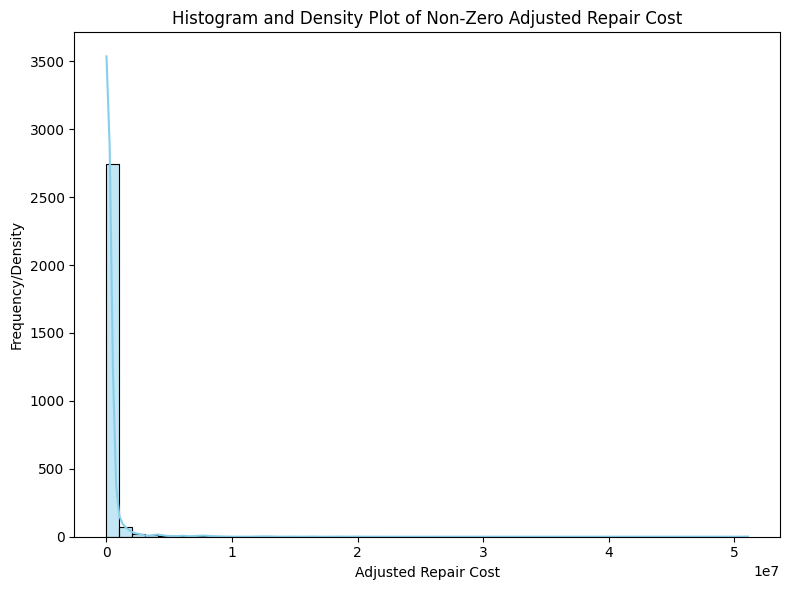

In [15]:
# Visualise the distribution of non-zero repair costs
plt.figure(figsize=(8, 6))

# Filter out zero values
sns.histplot(data[data['COST_REPAIRS_INFL_ADJ'] > 0]['COST_REPAIRS_INFL_ADJ'],
             kde=True, color='skyblue', bins=50)

plt.title('Histogram and Density Plot of Non-Zero Adjusted Repair Cost')
plt.xlabel('Adjusted Repair Cost')
plt.ylabel('Frequency/Density')
plt.tight_layout()
plt.show()

Keep in mind that the above plot already excluded repair costs = 0. In a standalone regression model, it might be hard to accurately predict the repair costs with such a heavy bias.

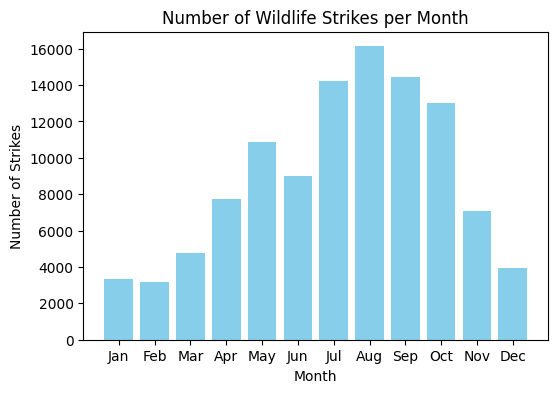

In [16]:
# Visualise number of strikes throughout the year (across months)
data_month = data.groupby('INCIDENT_MONTH').size().reset_index(name='STRIKE_COUNT')

plt.figure(figsize=(6,4))
plt.bar(data_month['INCIDENT_MONTH'], data_month['STRIKE_COUNT'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Strikes')
plt.title('Number of Wildlife Strikes per Month')
plt.xticks(data_month['INCIDENT_MONTH'],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

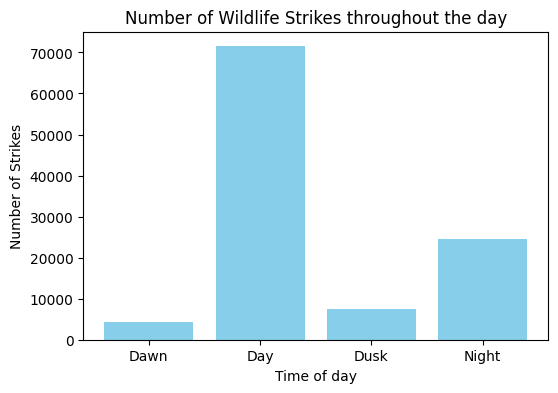

In [17]:
# Group by time of day and count the number of strikes
time_strikes = data.groupby('TIME_OF_DAY').size().reset_index(name='STRIKE_COUNT')

# Plot the data
plt.figure(figsize=(6,4))
plt.bar(time_strikes['TIME_OF_DAY'], time_strikes['STRIKE_COUNT'], color='skyblue')
plt.xlabel('Time of day')
plt.ylabel('Number of Strikes')
plt.title('Number of Wildlife Strikes throughout the day')
plt.xticks(time_strikes['TIME_OF_DAY'])
plt.show()

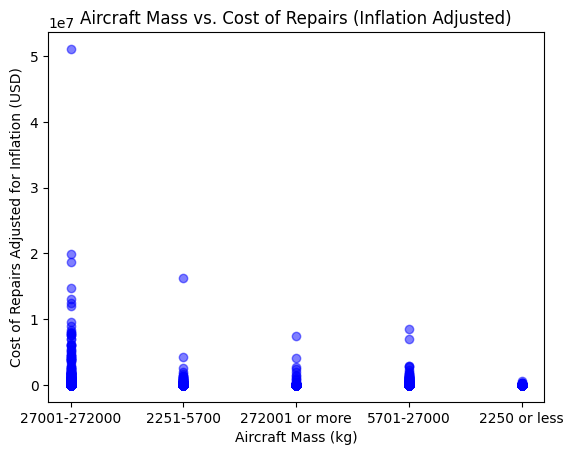

In [18]:
# Scatter plot of aircraft mass against cost of repairs
plt.scatter(data['AC_MASS'],data['COST_REPAIRS_INFL_ADJ'], color='b', alpha=0.5)

# Add labels and title
plt.xlabel('Aircraft Mass (kg)')
plt.ylabel('Cost of Repairs Adjusted for Inflation (USD)')
plt.title('Aircraft Mass vs. Cost of Repairs (Inflation Adjusted)')
plt.show()

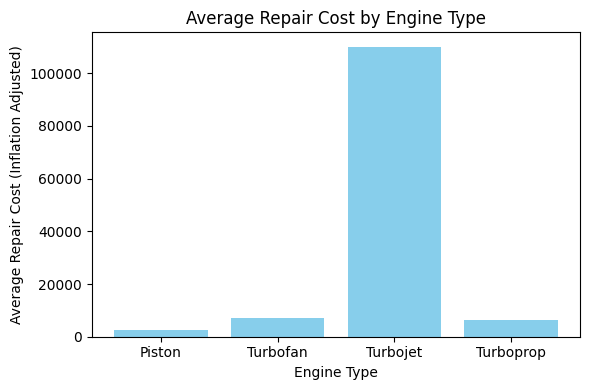

In [19]:
# Visualize the relationship between TYPE_ENG (engine type) and COST_REPAIRS_INFL_ADJ (adjusted repair cost)
eng_cost_summary = data.groupby('TYPE_ENG')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
eng_cost_summary.columns = ['Engine Type', 'Average Repair Cost']

# plot data
plt.figure(figsize=(6, 4))
plt.bar(eng_cost_summary['Engine Type'], eng_cost_summary['Average Repair Cost'], color='skyblue')
plt.xlabel('Engine Type')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Engine Type')
plt.tight_layout()
plt.show()

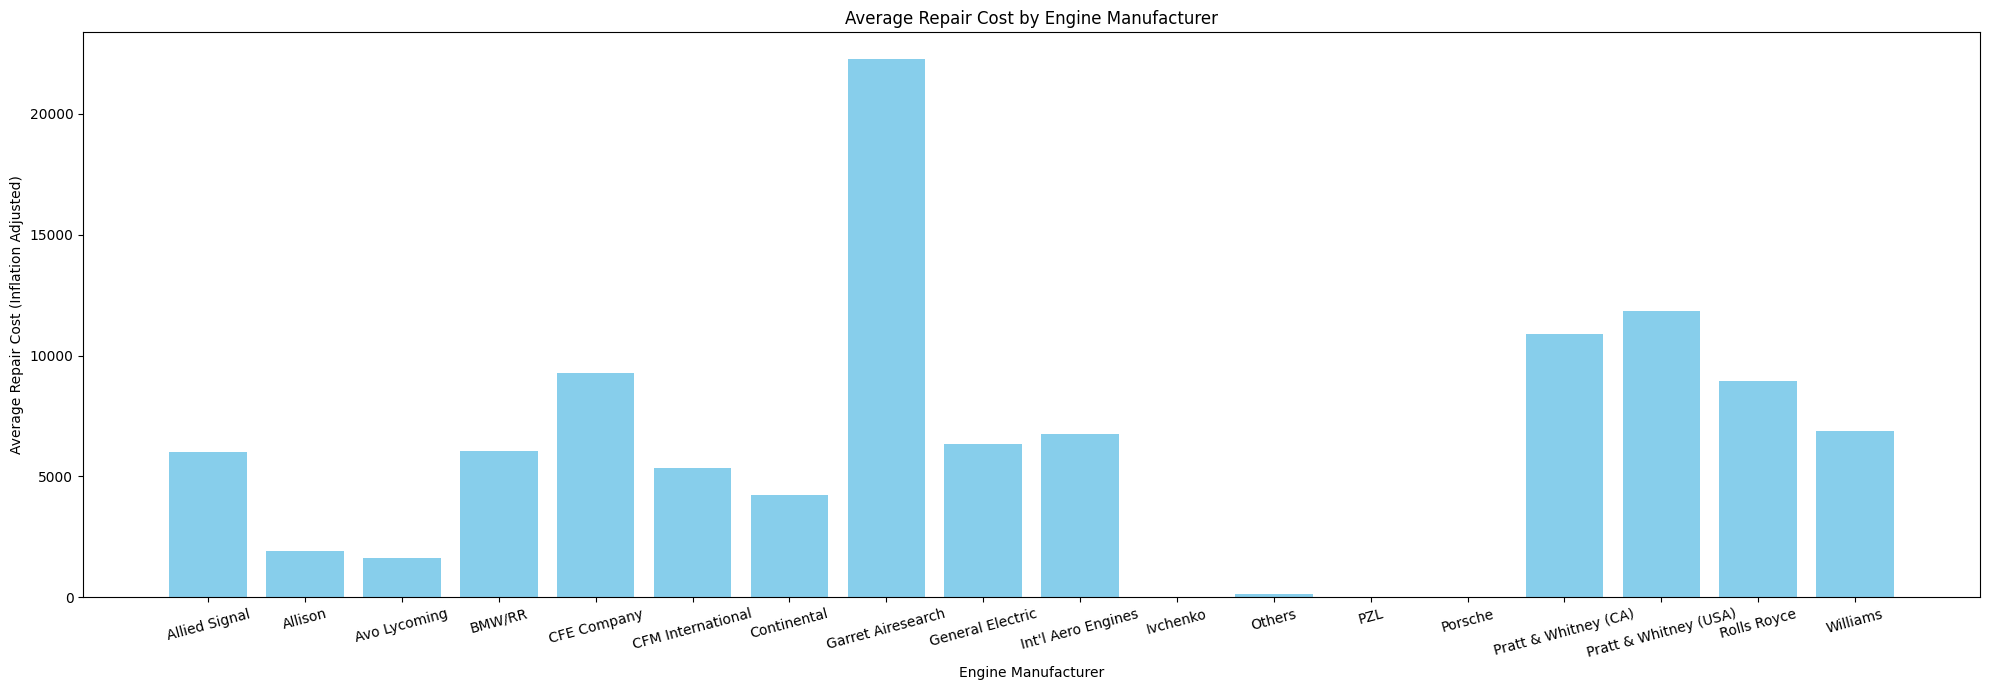

In [20]:
# Visualize the relationship between manufacturer of engine and adjusted repair cost
manu_cost_summary = data.groupby('ENGIN_MANUFACTURER')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
manu_cost_summary.columns = ['Engine Manufacturer', 'Average Repair Cost']

# plot data
plt.figure(figsize=(20, 7))
plt.bar(manu_cost_summary['Engine Manufacturer'], manu_cost_summary['Average Repair Cost'], color='skyblue')
plt.xlabel('Engine Manufacturer')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Engine Manufacturer')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

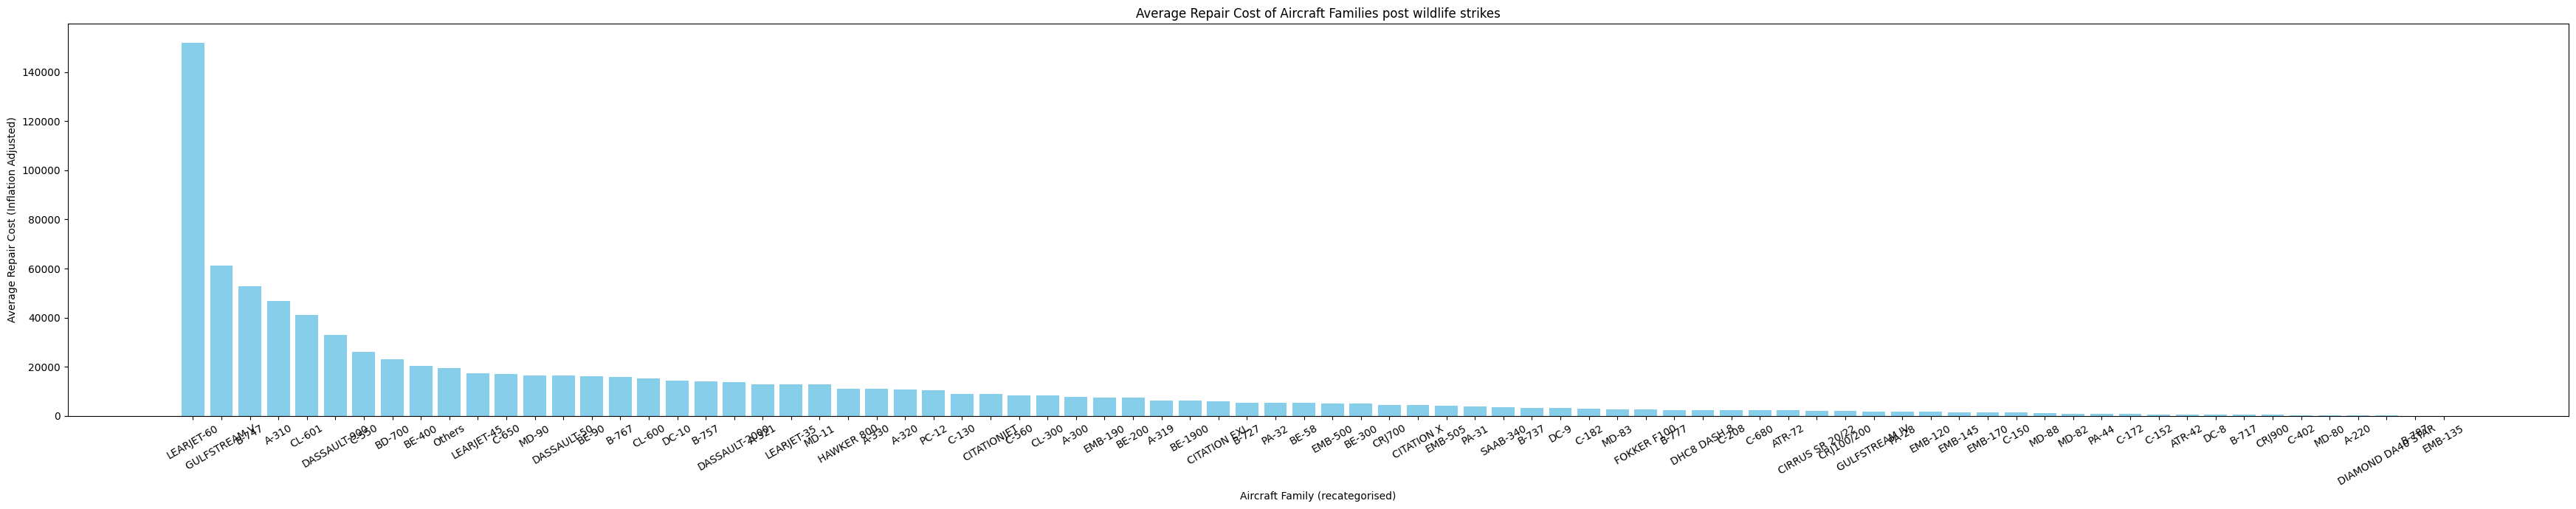

In [21]:
# Visualize the relationship between aircraft family and adjusted repair cost again
aircraft_cost_rev = data.groupby('AIRCRAFT_FAMILY_GROUPED')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
aircraft_cost_rev.columns = ['Aircraft Family revised', 'Average Repair Cost']

# Sort the dataframe by 'Average Repair Cost' in descending order
aircraft_cost_rev = aircraft_cost_rev.sort_values(by='Average Repair Cost', ascending=False)

# Plot data
plt.figure(figsize=(35, 7))
plt.bar(aircraft_cost_rev['Aircraft Family revised'], aircraft_cost_rev['Average Repair Cost'], color='skyblue')
plt.xlabel('Aircraft Family (recategorised)')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost of Aircraft Families post wildlife strikes')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

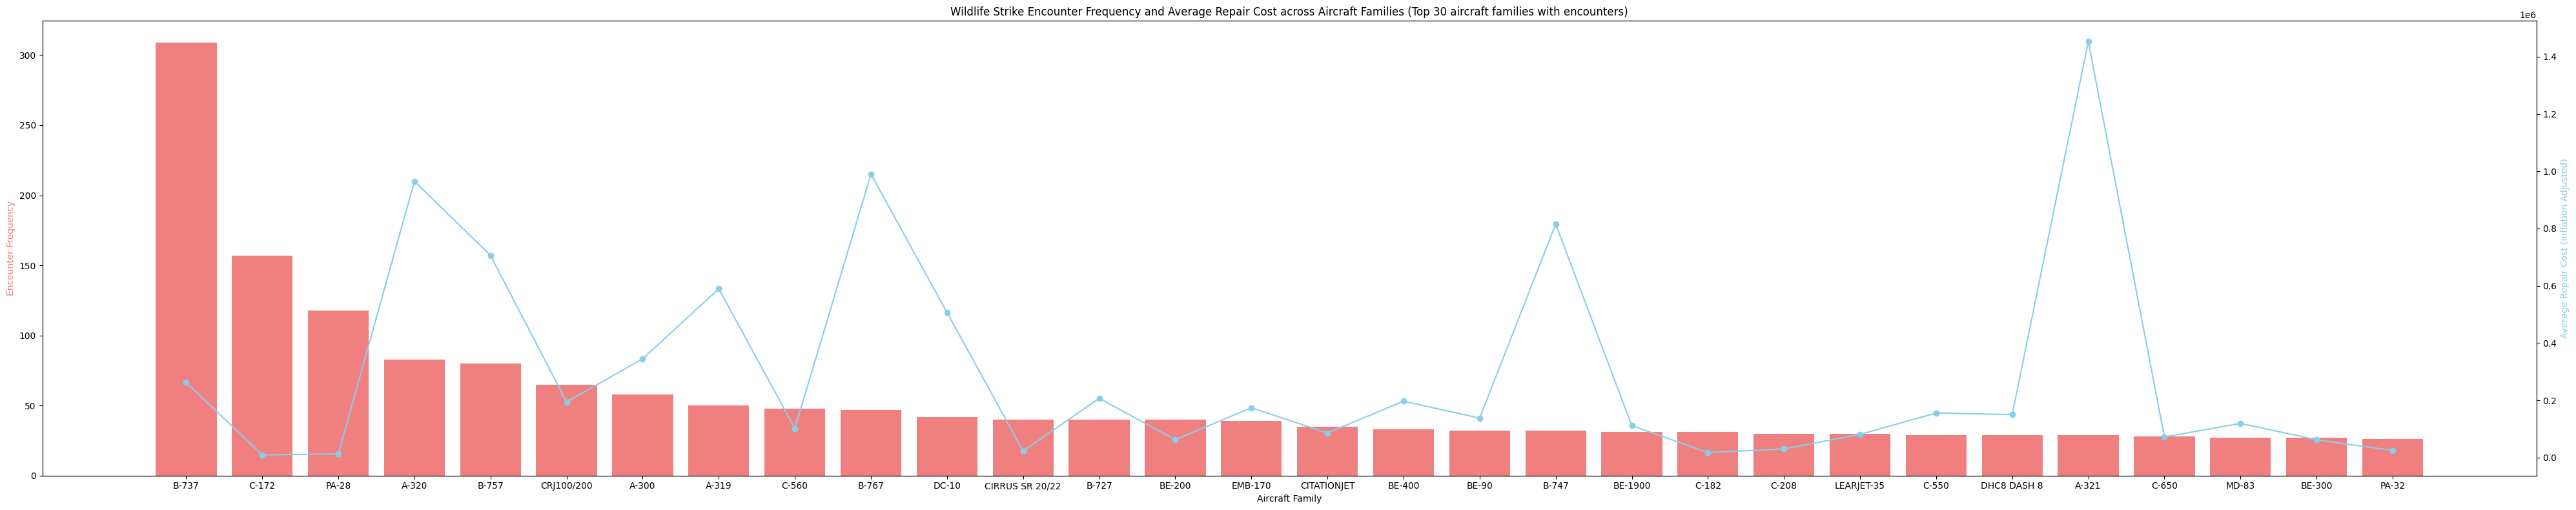

In [22]:
# Visualize the frequency of wildlife strike encounter incurring repair costs across aircrafts
# Filter the data for incidents where there are repair costs (i.e., COST_REPAIRS_INFL_ADJ > 0)
encounter_data = data[data['COST_REPAIRS_INFL_ADJ'] > 0]

# Group by 'AIRCRAFT_FAMILY_GROUPED' to get the frequency of wildlife strike encounters and average repair costs
aircraft_encounter_cost = encounter_data.groupby('AIRCRAFT_FAMILY').agg(
    encounter_count=('COST_REPAIRS_INFL_ADJ', 'size'),   # Count of encounters
    avg_repair_cost=('COST_REPAIRS_INFL_ADJ', 'mean')    # Average repair cost
).reset_index()

# Rename columns for clarity
aircraft_encounter_cost.columns = ['Aircraft Family', 'Encounter Count', 'Average Repair Cost']

# Sort the dataframe by 'Encounter Count' in descending order
aircraft_encounter_cost_sorted = aircraft_encounter_cost.sort_values(by='Encounter Count', ascending=False).head(30)

# Plot data
fig, ax1 = plt.subplots(figsize=(40, 8))

# Bar plot for encounter frequency (on the left axis)
ax1.bar(aircraft_encounter_cost_sorted['Aircraft Family'],
        aircraft_encounter_cost_sorted['Encounter Count'], color='lightcoral', label='Encounter Frequency')

# Twin the axes to plot repair cost on the same graph (right axis)
ax2 = ax1.twinx()
ax2.plot(aircraft_encounter_cost_sorted['Aircraft Family'],
         aircraft_encounter_cost_sorted['Average Repair Cost'], color='skyblue', marker='o', label='Average Repair Cost')

# Labels and Title
ax1.set_xlabel('Aircraft Family')
ax1.set_ylabel('Encounter Frequency', color='lightcoral')
ax2.set_ylabel('Average Repair Cost (Inflation Adjusted)', color='skyblue')
plt.title('Wildlife Strike Encounter Frequency and Average Repair Cost across Aircraft Families (Top 30 aircraft families with encounters)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

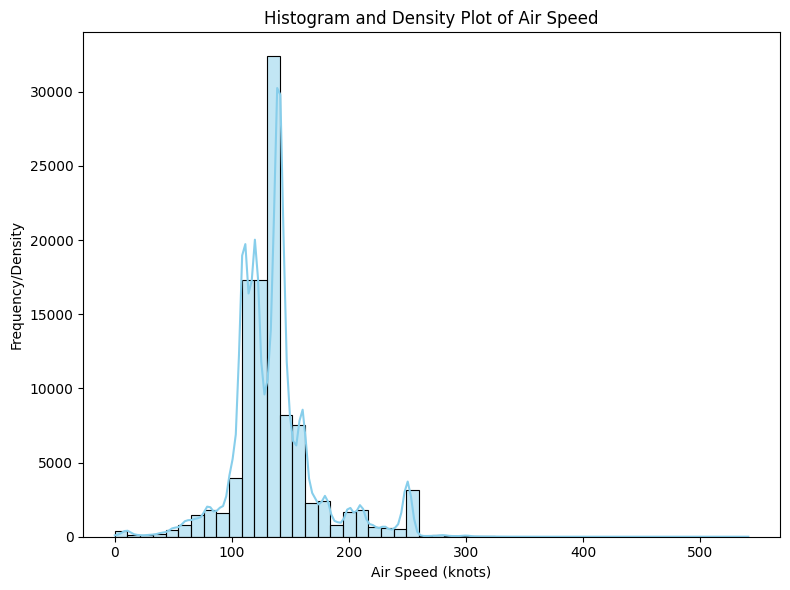

In [23]:
# Speed distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['SPEED'], kde=True, color='skyblue', bins=50)
plt.title('Histogram and Density Plot of Air Speed')
plt.xlabel('Air Speed (knots)')
plt.ylabel('Frequency/Density')
plt.tight_layout()
plt.show()

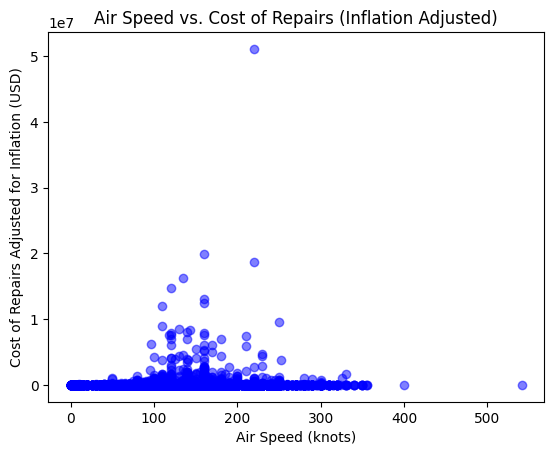

In [24]:
# Scatter plot of aircraft speed against cost of repairs
plt.scatter(data['SPEED'],data['COST_REPAIRS_INFL_ADJ'], color='b', alpha=0.5)

# Add labels and title
plt.xlabel('Air Speed (knots)')
plt.ylabel('Cost of Repairs Adjusted for Inflation (USD)')
plt.title('Air Speed vs. Cost of Repairs (Inflation Adjusted)')
plt.show()

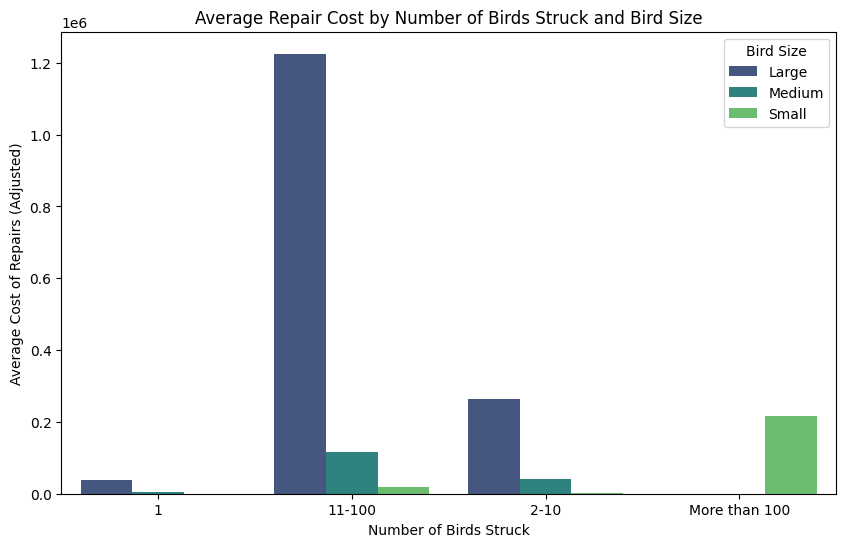

In [25]:
# Visualise relationship between cost and NUM_STRUCK and SIZE
grouped_data = data.groupby(['NUM_STRUCK', 'SIZE'])['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='NUM_STRUCK', y='COST_REPAIRS_INFL_ADJ', hue='SIZE', data=grouped_data, palette='viridis')
plt.xlabel('Number of Birds Struck')
plt.ylabel('Average Cost of Repairs (Adjusted)')
plt.title('Average Repair Cost by Number of Birds Struck and Bird Size')
plt.legend(title='Bird Size')
plt.show()

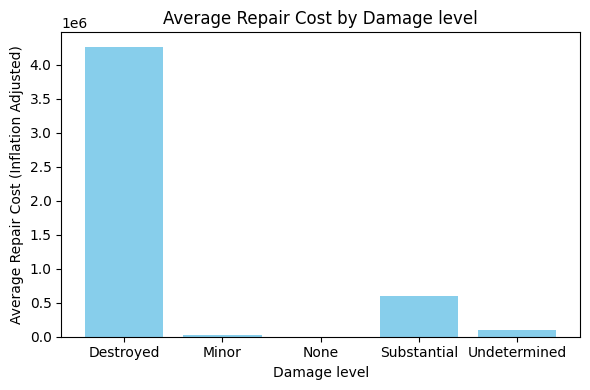

In [26]:
# Visualize the relationship between damage level and adjusted repair cost
damagelev_cost = data.groupby('DAMAGE_LEVEL')['COST_REPAIRS_INFL_ADJ'].mean().reset_index()

# Rename columns for clarity
damagelev_cost.columns = ['Damage level', 'Average Repair Cost']

# plot data
plt.figure(figsize=(6, 4))
plt.bar(damagelev_cost['Damage level'], damagelev_cost['Average Repair Cost'], color='skyblue')
plt.xlabel('Damage level')
plt.ylabel('Average Repair Cost (Inflation Adjusted)')
plt.title('Average Repair Cost by Damage level')
plt.tight_layout()
plt.show()

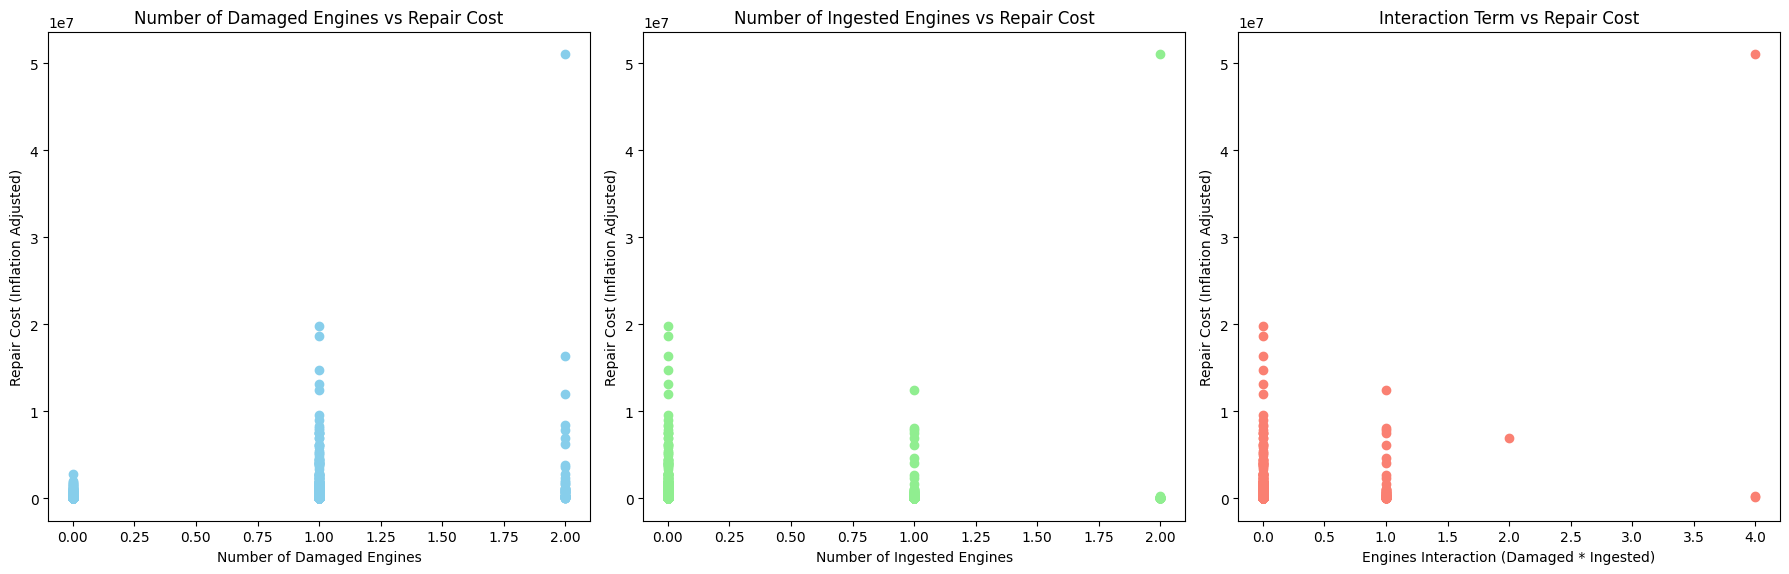

In [27]:
# Visualise the relationship between cost and each of the individual damage/ingested/interaction term variables
# Set up the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot NUM_DAM_ENGINES vs COST_REPAIRS_INFL_ADJ
axes[0].scatter(data['NUM_DAM_ENGINES'], data['COST_REPAIRS_INFL_ADJ'], color='skyblue')
axes[0].set_title('Number of Damaged Engines vs Repair Cost')
axes[0].set_xlabel('Number of Damaged Engines')
axes[0].set_ylabel('Repair Cost (Inflation Adjusted)')

# Plot NUM_ING_ENGINES vs COST_REPAIRS_INFL_ADJ
axes[1].scatter(data['NUM_ING_ENGINES'], data['COST_REPAIRS_INFL_ADJ'], color='lightgreen')
axes[1].set_title('Number of Ingested Engines vs Repair Cost')
axes[1].set_xlabel('Number of Ingested Engines')
axes[1].set_ylabel('Repair Cost (Inflation Adjusted)')

# Plot ENGINES_INTERACTION vs COST_REPAIRS_INFL_ADJ
axes[2].scatter(data['ENGINES_INTERACTION'], data['COST_REPAIRS_INFL_ADJ'], color='salmon')
axes[2].set_title('Interaction Term vs Repair Cost')
axes[2].set_xlabel('Engines Interaction (Damaged * Ingested)')
axes[2].set_ylabel('Repair Cost (Inflation Adjusted)')

plt.tight_layout()
plt.show()

Further processing of the data

In [28]:
def final_process(df):
    df = df.drop(columns=['AIRPORT_LATITUDE', 'AIRPORT_LONGITUDE', 'AIRCRAFT_FAMILY_GROUPED'])
    return df

final_data = final_process(data)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107764 entries, 59 to 310726
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   INCIDENT_MONTH               107764 non-null  int64  
 1   TIME_OF_DAY                  107764 non-null  object 
 2   AIRPORT_ID                   107764 non-null  object 
 3   AC_MASS                      107764 non-null  object 
 4   TYPE_ENG                     107764 non-null  object 
 5   SPEED                        107764 non-null  float64
 6   DAMAGE_LEVEL                 107764 non-null  object 
 7   DAM_RAD                      107764 non-null  bool   
 8   DAM_WINDSHLD                 107764 non-null  bool   
 9   DAM_NOSE                     107764 non-null  bool   
 10  INGESTED_OTHER               107764 non-null  bool   
 11  DAM_PROP                     107764 non-null  bool   
 12  DAM_WING_ROT                 107764 non-null  bool   
 13  DAM

### **Causal Inference**

**Context**

Boeing is one of the world's largest aircraft manufacturers, producing a variety of aircraft models for commercial aviation. Among them, the Boeing 737 (B-737) stands as one of the most iconic and widely used aircraft globally. In March 2018, the B-737 broke the Guiness World Records title for the most produced commercial jet aircraft model, with 10000 aircraft deliveries. Renowned for its efficiency, reliability, and lower operational costs, the B-737 remains a staple in airlines' fleets worldwide.

In the context of wildlife strikes, it is essential to understand the impact that different aircraft models may have on the repair costs following a wildlife encounter. Aircraft characteristics such as airframe design, engine types (as well as their manufacturers), and damage susceptibility can vary significantly, leading to differing levels of damage severity and repair costs. These differences are important to consider, as they could directly influence how effectively airlines can manage the economic impact of wildlife encounters.

With B-737 as one of the most widely deployed aircraft and its prevalence in the airline industry, it is worth investigating whether standardising a fleet to include higher proportion of B-737s could lower overall repair costs incurred by companies after wildlife strikes.

As highlighted in the plot above titled 'Wildlife Strike Encounter Frequency and Average Repair Cost across Aircraft Families (Top 30 aircraft families with encounters)', the B-737 had the highest frequency of wildlife strike encounters. Despite its frequency exposure to wildlife strikes, the average repair cost remains relatively low. This phenomenon can be attributed to ease of access to repair parts, resilient design and engine type among other potential contributing factors.

Thus, the goal of this analysis aims to explore whether increasing proportion of B-737s in an airline's fleet can reduce overall repair costs. For better focus of analysis, only encounters with repair costs will be considered.

#### Final set up of dataset for analysis

The data is further processed to omit encounters that did not incur any repair costs (2884 rows).

To reduce dimensionality of the dataset, the damaged components are also reduced to focus on 3 main components of the plane that have huge influence over aircraft repair costs: damaged engines, wing/rotor and landing gear. The other parts of the plane that incurred damage will be encoded 1 if any of the windshield, nose, propeller, fuse, tail, lights or randome was damaged, and 0 if none of them did.

Other variables such as the aircraft mass, airport id, incident month and engine manufacturer will also be disregarded as they may not have a strong causal relationship with the outcome. Though engine manufacturer might have an influence, it introduces too much complexity into the model.

Wildlife size grouping will also be revised based on the plot 'Average Repair Cost by Number of Birds Struck and Bird Size'. It is observed that the average cost of repair incurred from hitting wildlife classified as small and medium sized did not differ significantly across the number of wildlife struck. Thus, small and medium sized wildlife will be treated as a single group for analysis.

In [31]:
def causal_prep(df):
  # Filter out encounters with zero repair costs
  df = df[df['COST_REPAIRS_INFL_ADJ'] > 0] # dataset dropped to 2884 rows
  # Feature engineer damaged variables into 3 main components only: damage to wing/rotor, damage to landing gear
  df['DAM_OTHERS'] = df[['DAM_WINDSHLD', 'DAM_NOSE', 'DAM_PROP', 'DAM_FUSE', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_RAD', 'DAM_OTHER']].any(axis=1)
  # Convert boolean to integer
  for d in ['DAM_OTHERS','DAM_LG','DAM_WING_ROT']:
    df[d] = df[d].astype(int)
  # Remove features that significantly increase dimensionality but add little value towards the causal analysis. To also consider just damaged engine count and omit ingested count
  df = df.drop(columns=['AIRPORT_ID','AC_MASS', 'ENGIN_MANUFACTURER', 'INCIDENT_MONTH', 'DAM_WINDSHLD', 'DAM_NOSE', 'DAM_PROP', 'DAM_FUSE', 'DAM_TAIL', 'DAM_LGHTS', 'DAM_RAD', 'DAM_OTHER', 'INGESTED_OTHER', 'NUM_ING_ENGINES'])
  # Revise grouping for size of wildlife according to the plot above 'Average Repair Cost by Number of Birds Struck and Bird Size'
  df['SIZE'] = df['SIZE'].replace({'Small': 'Small/Medium', 'Medium': 'Small/Medium'})
  # Rename wildlife variable for interpretability
  df = df.rename(columns={'SIZE': 'WILDLIFE_SIZE'})
  # Revise grouping of time of day into 2 big umbrella terms: Day and Night
  df['TIME_OF_DAY'] = df['TIME_OF_DAY'].replace({'Dawn': 'Day', 'Dusk': 'Night'})
  return df

df = causal_prep(final_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2884 entries, 1576 to 310710
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TIME_OF_DAY                  2884 non-null   object 
 1   TYPE_ENG                     2884 non-null   object 
 2   SPEED                        2884 non-null   float64
 3   DAMAGE_LEVEL                 2884 non-null   object 
 4   DAM_WING_ROT                 2884 non-null   int64  
 5   DAM_LG                       2884 non-null   int64  
 6   NUM_STRUCK                   2884 non-null   object 
 7   WILDLIFE_SIZE                2884 non-null   object 
 8   COST_REPAIRS_INFL_ADJ        2884 non-null   float64
 9   AIRCRAFT_FAMILY              2884 non-null   object 
 10  log1p_COST_REPAIRS_INFL_ADJ  2884 non-null   float64
 11  NUM_DAM_ENGINES              2884 non-null   int64  
 12  ENGINES_INTERACTION          2884 non-null   int64  
 13  DAM_OTHERS        

### Final Data Description

Eventual dataset for causal analysis was reduced to 2884 wildlife strike encounters incurring a repair cost.

Variables in the dataset include the following:

*   TIME_OF_DAY: An indication of when the wildlife strike occurred in the day
*   TYPE_ENG: The type of engine the aircraft had
* SPEED: Speed of aircraft on strike
* DAMAGE_LEVEL: Overall damage done to the aircraft in pre-defined categories in the initial repaort
* DAM_WING_ROT/DAM_LG/DAM_OTHERS: Binary variables indicating whether damage was incurred on the wing/rotor, landing gear or other parts of the plane
* NUM_DAM_ENGINES: A numercial variable that indicates the number of engines that got damaged post strike. Number ranges from 0 to a maximum possible 4
* NUM_STRUCK/ WILDLIFE_SIZE: Variables describing the nature of the wildlife that the aircraft encountered. Both are categorical in nature, groupings pre-defined in the initial report
* AIRCRAFT_FAMILY: Categorical variable feature engineered to group aircrafts within the same family together eg B-737-800 and B-737-900 are grouped into B-737
* ENGINES_INTERACTION: Interaction term that was computed based on the number of engines ingested and damaged
* log1p_COST_REPAIRS_INFL_ADJ/ COST_REPAIRS_INFL_ADJ: Numerical variables indicating the cost incurred for repairs. Former has undergone log transformation to reduce skew and will be the target for analysis



Define variables for causal inference

In [32]:
# Set up treatment and outcome variables
df['Treatment'] = np.where(df['AIRCRAFT_FAMILY'] == 'B-737', 1, 0)
T = df['Treatment'].values
Y = df['log1p_COST_REPAIRS_INFL_ADJ'].values

# Set up features/ covariates
features = df.drop(columns=['COST_REPAIRS_INFL_ADJ', 'log1p_COST_REPAIRS_INFL_ADJ', 'Treatment', 'AIRCRAFT_FAMILY'])

# Encode categorical variables
cat_cols = features.select_dtypes(include=['object']).columns.tolist()
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), cat_cols)],
    remainder='passthrough' # keep other columns as is
)
X_encoded = encoder.fit_transform(features)

# Convert the encoded features back into a dataframe
X = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out())

T.shape, Y.shape, X.shape

((2884,), (2884,), (2884, 17))

In [33]:
# Inspect feature data frame
X.info()

# Set up feature names
feature_names = X.columns.tolist()
feature_names = [name.split('__')[1] if '__' in name else name for name in feature_names]

# Set up model tau
model_tau = LGBMRegressor(random_state=5, importance_type='gain')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884 entries, 0 to 2883
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cat__TIME_OF_DAY_Night           2884 non-null   float64
 1   cat__TYPE_ENG_Turbofan           2884 non-null   float64
 2   cat__TYPE_ENG_Turbojet           2884 non-null   float64
 3   cat__TYPE_ENG_Turboprop          2884 non-null   float64
 4   cat__DAMAGE_LEVEL_Minor          2884 non-null   float64
 5   cat__DAMAGE_LEVEL_Substantial    2884 non-null   float64
 6   cat__DAMAGE_LEVEL_Undetermined   2884 non-null   float64
 7   cat__NUM_STRUCK_11-100           2884 non-null   float64
 8   cat__NUM_STRUCK_2-10             2884 non-null   float64
 9   cat__NUM_STRUCK_More than 100    2884 non-null   float64
 10  cat__WILDLIFE_SIZE_Small/Medium  2884 non-null   float64
 11  remainder__SPEED                 2884 non-null   float64
 12  remainder__DAM_WING_

### Analysis Approach

**Meta-Learners**

Four meta-learners—S, T, X, and R—were used to estimate the treatment effect, allowing for comparison across different methodologies. To ensure comparability, Light Gradient Boosting Machine (LGBM) served as the primary base learner for all models.  Additionally, Random Forest and XGBoost base learners were explored with the X and T learners respectively to assess the sensitivity of these models to base learner choice.  The analysis will be conducted in two parts:

1. **Average treatment effect (ATE)** will first be analysed to understand if there is any difference in aircraft repair cost depending on whether the aircraft belongs to the Boeing 737 family. The comparison will be done across all meta-learners.

2. **Conditional average treatment effect (CATE)** will then explore whether using a B-737 will have a difference in repair cost depending on the following features: time of day, number of wildlife struck, number of damaged engines and the type of aircraft engines. The effect will be analysed just based upon a single meta-learner to understand if there are differences between subgroups.

- Time of day: Time of day can influence repair costs due to factors such as visibility, operational stress, availability of resources/ maintenance crew to work on the aircraft.
- Number of wildlife struck: Though categorical in this dataset, there is still value to be gained by analysing the data on this front. A high number of wildlife strikes typically leads to more severe damage and higher repair costs, to an arguably higher extent than just the size alone.
- Number of damaged engines: Engine damage is one of the most costly repairs for aircraft, and the number of damaged engines directly impacts repair costs. Assessing the effect of aircraft type (in this instance B-737 or not) can be valuable in informing airline operators on how repair costs scale with engine damage for B-737 compared to other aircrafts.
- Type of aircraft engine: Different engine types have different repair costs due to differences in design, materials and maintenance.

  This section of analysis can reveal whether the effect of using B-737 on repair cost varies across different groups, which can provide actionable insights for airlines and manufacturers.



**DoWhy** 

However, given the complexity of the investigation and the need to control for potential confounding variables, I also incorporated DoWhy to estimate the ATE. DoWhy offers a more structured approach to causal inference by leveraging causal graphs and formal methods such as the backdoor adjustment to identify and control for confounders. This allows for a more rigorous examination of causal relationships, addressing potential biases that could affect the estimates derived from the meta-learners.

By combining both methods, I aim to ensure a comprehensive understanding of the causal effect, and overall findings across both methods will be discussed.

#### S-Learner

Single model that learns the relationship across all the features within the dataset, including the treatment assignment to estimate the effect of treatment on outcome.

In [37]:
slearner = BaseSRegressor(LGBMRegressor(random_state=5))
s_ate= slearner.estimate_ate(X, T, Y)[0]
s_ite = slearner.fit_predict(X, T, Y)

# Inverse log the calculated ATE because Y had undergone log transformation
s_ate = np.expm1(s_ate)
s_ite = np.expm1(s_ite)

print('Average treatment effect using LGBM S-learner:', s_ate)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 2884, number of used features: 16
[LightGBM] [Info] Start training from score 10.000870
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 2884, number of used features: 16
[LightGBM] [Info] Start training from score 10.000870
Average treatment effect using LGBM S-learner: -0.12644847686449534


In [38]:
slearner.get_importance(X=X,
                        tau=s_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names,
                        random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: SPEED                         0.324938
 WILDLIFE_SIZE_Small/Medium    0.171722
 TYPE_ENG_Turbofan             0.078506
 DAMAGE_LEVEL_Minor            0.077970
 NUM_DAM_ENGINES               0.076791
 DAMAGE_LEVEL_Undetermined     0.065703
 DAM_WING_ROT                  0.062216
 TIME_OF_DAY_Night             0.052226
 DAMAGE_LEVEL_Substantial      0.041640
 DAM_OTHERS                    0.021957
 NUM_STRUCK_2-10               0.015472
 DAM_LG                        0.006411
 ENGINES_INTERACTION           0.003577
 TYPE_ENG_Turboprop            0.000803
 NUM_STRUCK_11-100             0.000068
 NUM_STRUCK_More than 100      0.000000
 TYPE_ENG_Turbojet             0.000000
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

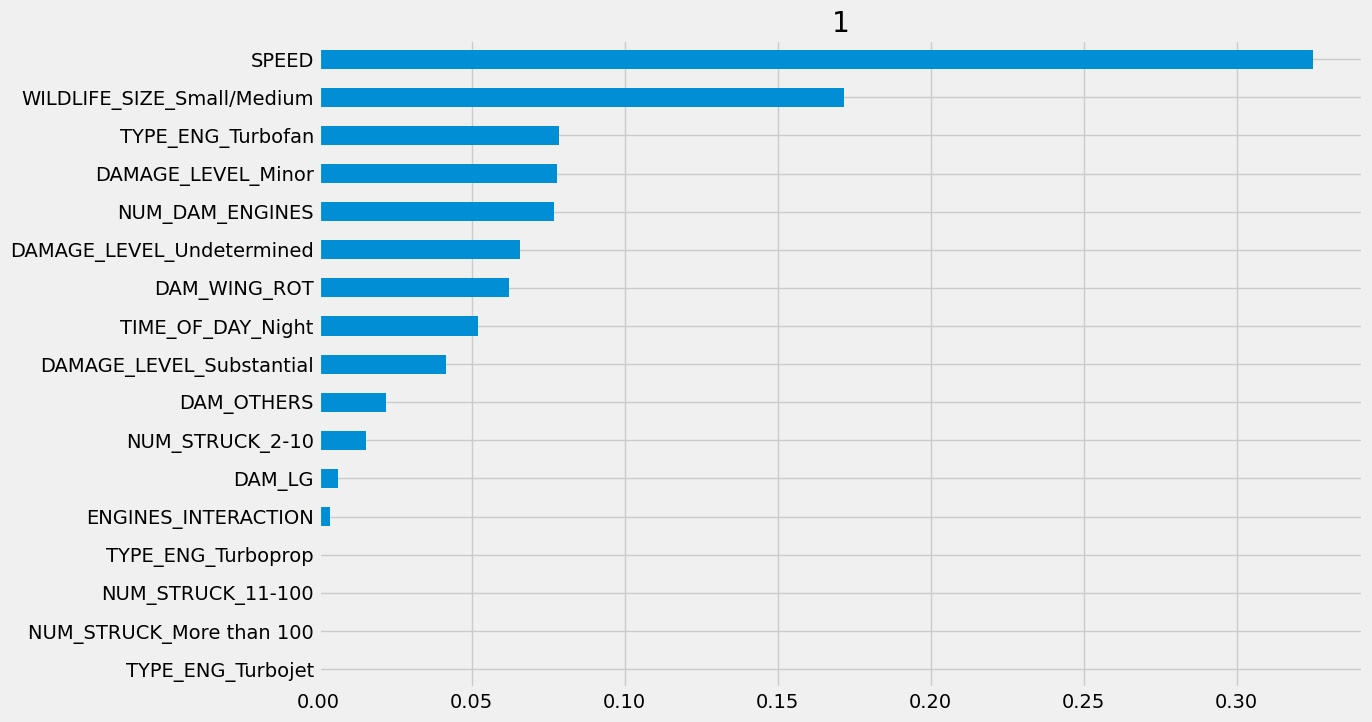

In [39]:
slearner.plot_importance(X=X,
                         tau=s_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names,
                         random_state=5)

In [40]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, s_ite, test_size=0.2, shuffle=True, random_state=5)

model_tau_s = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(model_tau_s,
                                       X_test,
                                       y_test,
                                       random_state=5).importances_mean

pd.Series(perm_imp_test, index=feature_names).sort_values(ascending=False)
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 2307, number of used features: 15
[LightGBM] [Info] Start training from score -0.091799
--- 0.9212594032287598 seconds ---


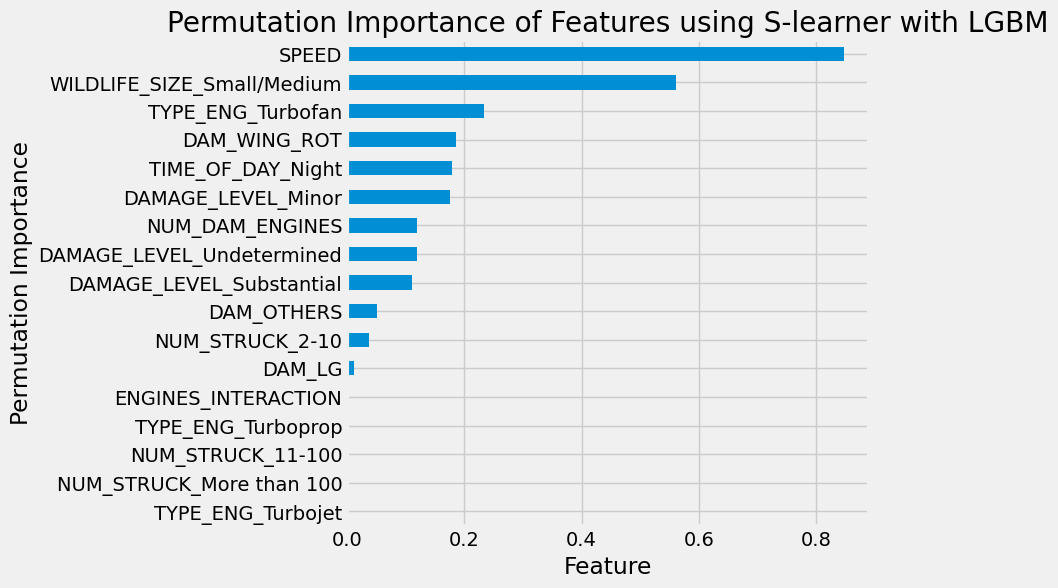

In [41]:
pd.Series(perm_imp_test, index=feature_names).sort_values().plot(kind='barh', figsize=(6, 6))
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features using S-learner with LGBM')
plt.show()

The most notable difference in feature importance for the S-learner with the introduction of train-test split are the rankings for variables pertaining to time of day and damage to wing/rotor. It will be interesting to explore how the rankings change for the other learners, but for now, it seems like speed, wildlife size and the type of engines have been conferred a higher importance in estimating the effect of treatment.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

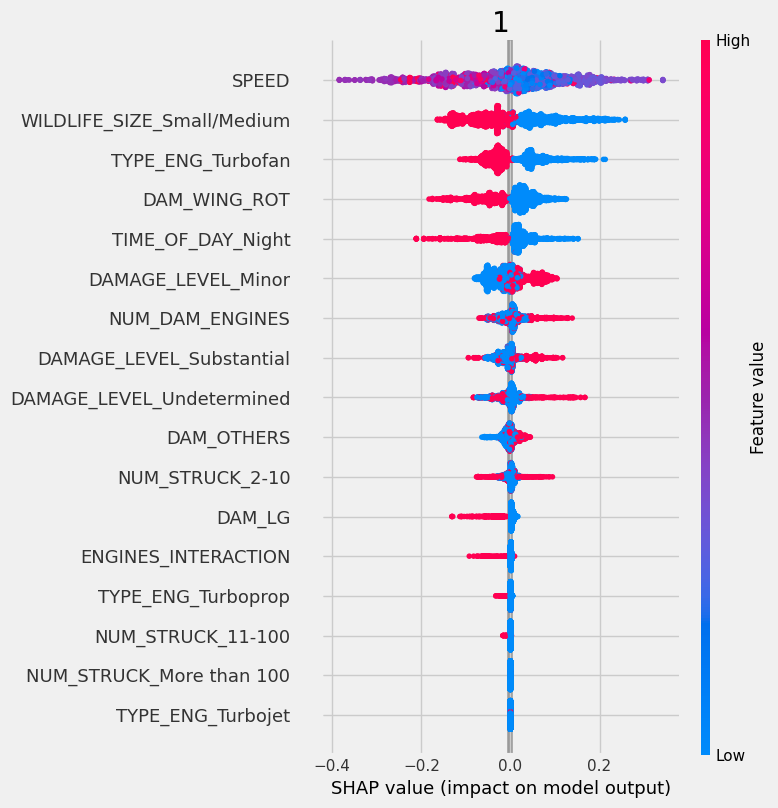

In [42]:
slearner.plot_shap_values(X,s_ite, features=feature_names)

### T-learner
2 models were used - 1 with LGBM as the base learner, and 1 with XGBRegressor to compare the sensitivity of T-learner model to the base learners.

In [43]:
# LGBM base learner
tlearnerl = BaseTRegressor(LGBMRegressor(random_state=5))
t_atel = tlearnerl.estimate_ate(X, T, Y)[0][0]
t_itel = tlearnerl.fit_predict(X, T, Y)

# Inverse log the calculated ATE because Y had undergone log transformation
t_atel = np.expm1(t_atel)
t_itel = np.expm1(t_itel)

# XGB base learner
tlearnerx = BaseTRegressor(XGBRegressor(random_state=5))
t_atex = tlearnerx.estimate_ate(X, T, Y)[0][0]
t_itex = tlearnerx.fit_predict(X, T, Y)

t_atex = np.expm1(t_atex)
t_itex = np.expm1(t_itex)

print('Average treatment effect using LGBM T-learner:',t_atel)
print('Average treatment effect using XGB T-learner:',t_atex)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 2575, number of used features: 15
[LightGBM] [Info] Start training from score 9.951078
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 309, number of used features: 11
[LightGBM] [Info] Start training from score 10.415802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

It is fascinating that the T-learner had different ATE with the base learner models were changed -- the ATE was found to be in opposite directions. It will be interesting to see how the feature importance differs and how the values might differ compared to the other learner models, more specifically against the X-learner which might be a better choice considering the nature of the dataset.

In [45]:
tlearnerl.get_importance(X=X,
                        tau=t_itel,
                        normalize=True,
                        method='auto',
                        features=feature_names,
                        random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: SPEED                         0.352372
 TYPE_ENG_Turbofan             0.176554
 WILDLIFE_SIZE_Small/Medium    0.104530
 TYPE_ENG_Turboprop            0.077514
 DAMAGE_LEVEL_Minor            0.065946
 DAM_WING_ROT                  0.042692
 DAM_OTHERS                    0.042684
 DAMAGE_LEVEL_Undetermined     0.038371
 DAMAGE_LEVEL_Substantial      0.031756
 DAM_LG                        0.027951
 TIME_OF_DAY_Night             0.018660
 NUM_DAM_ENGINES               0.011299
 NUM_STRUCK_2-10               0.008757
 NUM_STRUCK_11-100             0.000884
 ENGINES_INTERACTION           0.000030
 NUM_STRUCK_More than 100      0.000000
 TYPE_ENG_Turbojet             0.000000
 dtype: float64}

In [46]:
tlearnerx.get_importance(X=X,
                        tau=t_itex,
                        normalize=True,
                        method='auto',
                        features=feature_names,
                        random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: SPEED                         0.346040
 DAMAGE_LEVEL_Substantial      0.132514
 WILDLIFE_SIZE_Small/Medium    0.084865
 NUM_STRUCK_2-10               0.068668
 DAM_WING_ROT                  0.061539
 DAMAGE_LEVEL_Minor            0.058661
 DAM_OTHERS                    0.053777
 TYPE_ENG_Turbofan             0.049439
 NUM_DAM_ENGINES               0.046161
 DAM_LG                        0.035255
 TIME_OF_DAY_Night             0.025022
 TYPE_ENG_Turboprop            0.023252
 DAMAGE_LEVEL_Undetermined     0.010425
 NUM_STRUCK_11-100             0.004105
 ENGINES_INTERACTION           0.000278
 NUM_STRUCK_More than 100      0.000000
 TYPE_ENG_Turbojet             0.000000
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

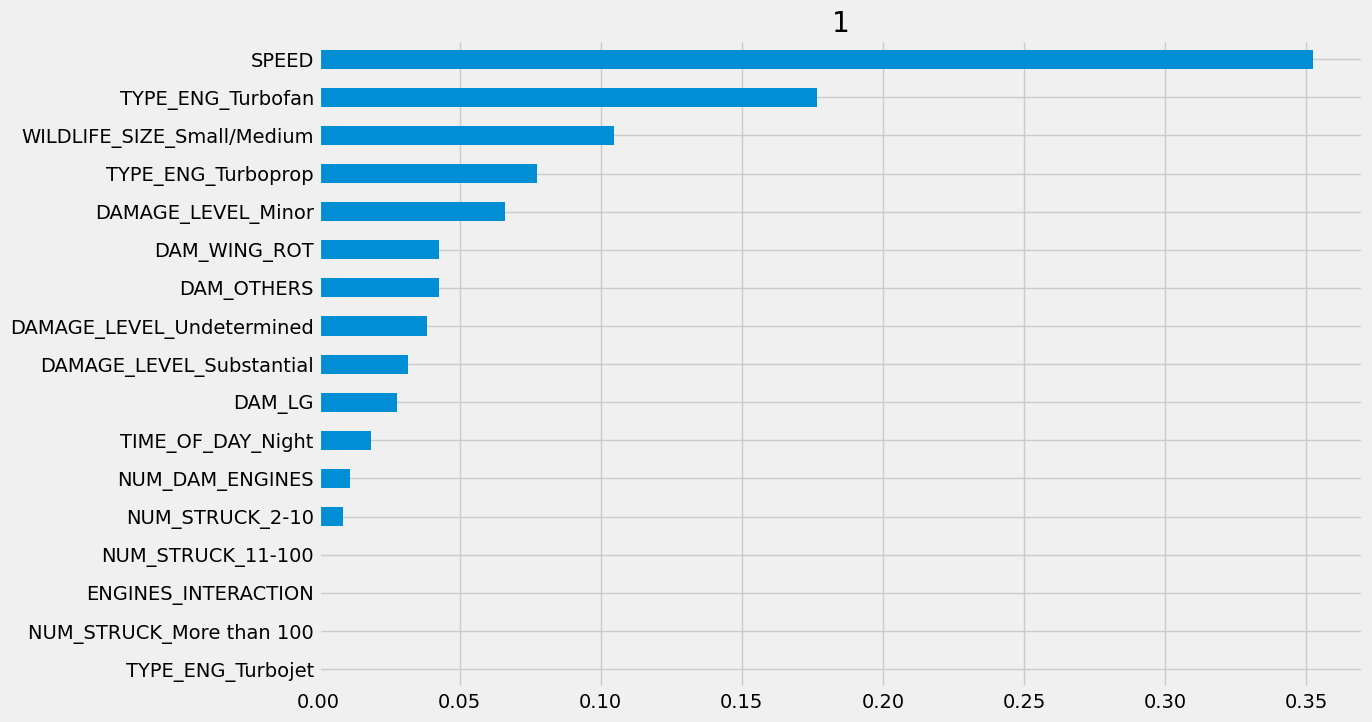

In [47]:
tlearnerl.plot_importance(X=X,
                         tau=t_itel,
                         normalize=True,
                         method='auto',
                         features=feature_names,
                         random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

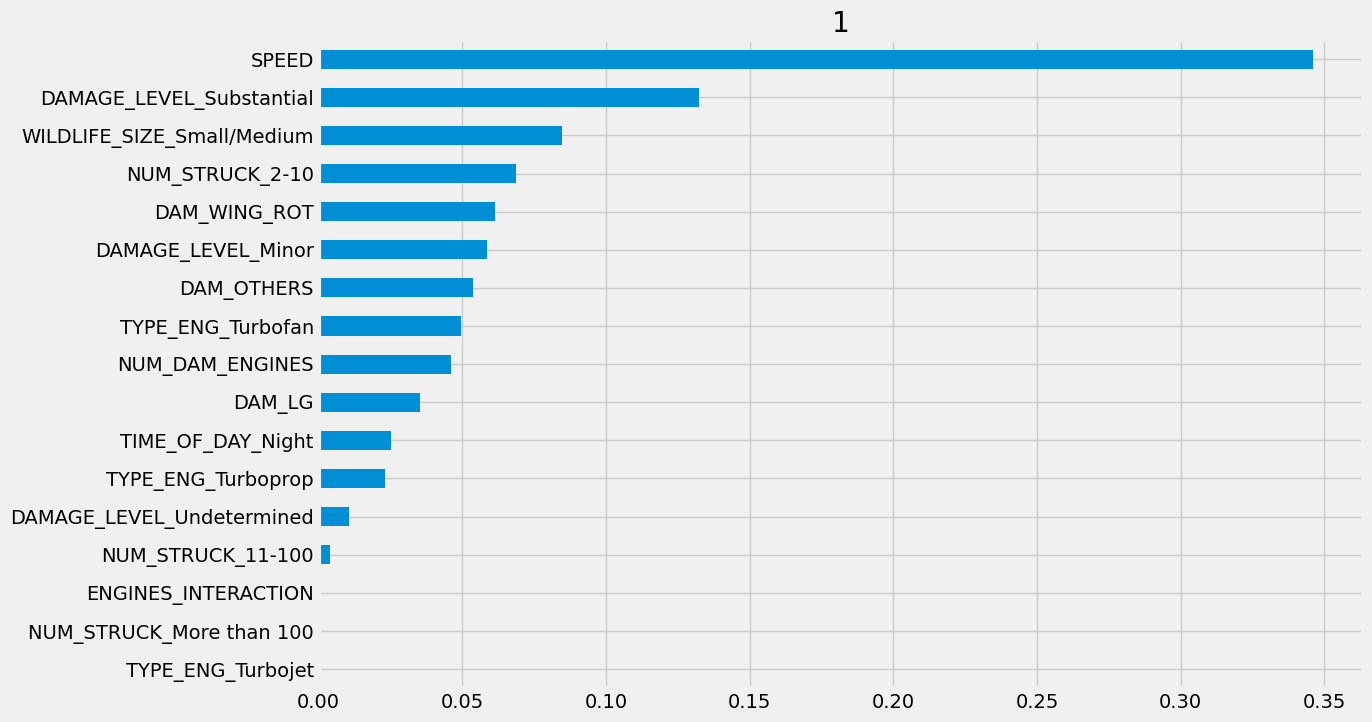

In [48]:
tlearnerx.plot_importance(X=X,
                         tau=t_itex,
                         normalize=True,
                         method='auto',
                         features=feature_names,
                         random_state=5)

Between the 2 T-learners, it can be seen that the feature importance deviate. In the XGBoost base learner (2nd plot), more emphasis was given to the nature of wildlife strike in terms of the size and the number of wildlife on impact, which probably accounted for the difference in ATE scores as previously observed.
That said, the extent of damage was always a top consideration which aligns with expectation considering that it has a direct implication on the actual repair cost. It is also interesting to see that the type of engine - turbofan and turbofan both turned out to be more important than turbojet.

In [51]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, t_itel, test_size=0.2, shuffle=True, random_state=5)

model_tau_tl = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(model_tau_tl,
                                       X_test,
                                       y_test,
                                       random_state=5).importances_mean

pd.Series(perm_imp_test, index=feature_names).sort_values(ascending=False)
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 2307, number of used features: 15
[LightGBM] [Info] Start training from score 1.983561
--- 0.6939353942871094 seconds ---


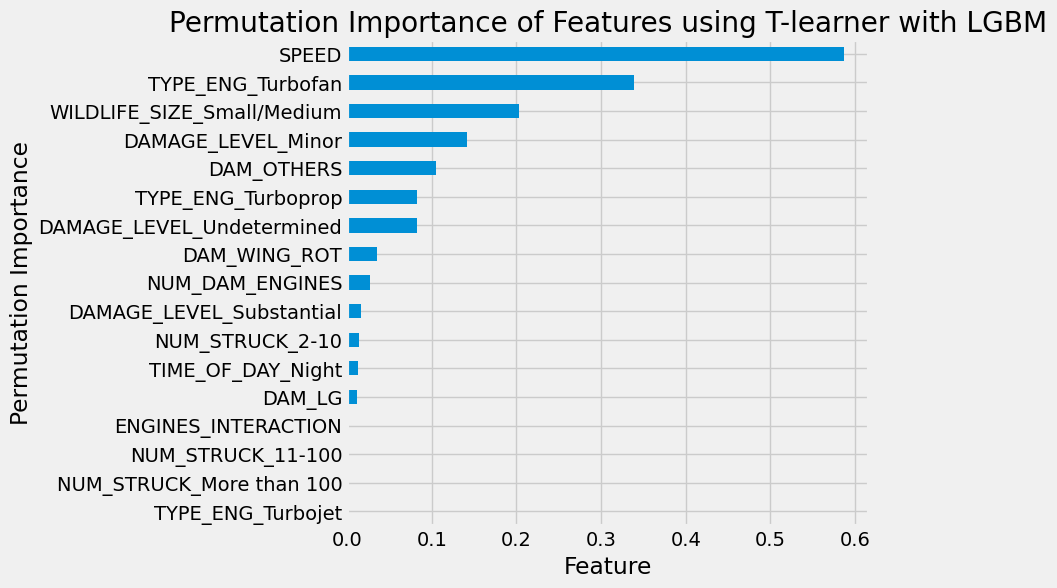

In [52]:
pd.Series(perm_imp_test, index=feature_names).sort_values().plot(kind='barh', figsize=(6, 6))
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features using T-learner with LGBM')
plt.show()

In [53]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, t_itex, test_size=0.2, shuffle=True, random_state=5)

model_tau_tx = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(model_tau_tx,
                                       X_test,
                                       y_test,
                                       random_state=5).importances_mean

pd.Series(perm_imp_test, index=feature_names).sort_values(ascending=False)
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 2307, number of used features: 15
[LightGBM] [Info] Start training from score 4.877621
--- 1.043856143951416 seconds ---


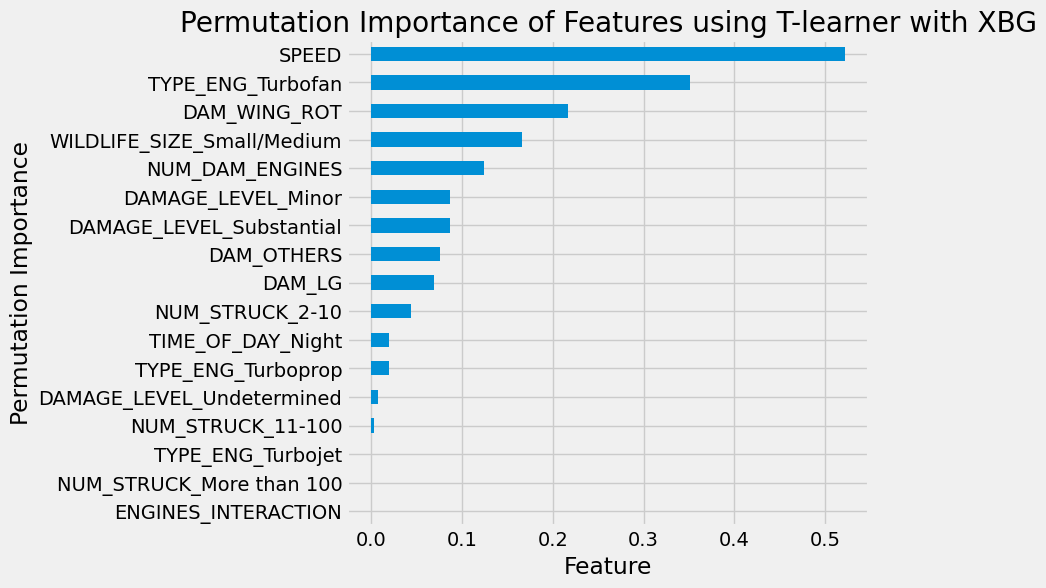

In [54]:
pd.Series(perm_imp_test, index=feature_names).sort_values().plot(kind='barh', figsize=(6, 6))
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features using T-learner with XBG')
plt.show()

The introduction of a train-test split resulted in noticeable changes in feature importance. While speed remained the most influential variable, the relative importance of other features shifted. This is likely due to the train-test split creating datasets with different distributions compared to the original data. As feature importance is inherently data-dependent, the model trained on the training set emphasizes different aspects of the data. In the context of the T-learner, which trains separate models for the treated and control groups, the splitting of the data can further exacerbate this effect if the distributions of these groups vary substantially between the training set and the full dataset.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

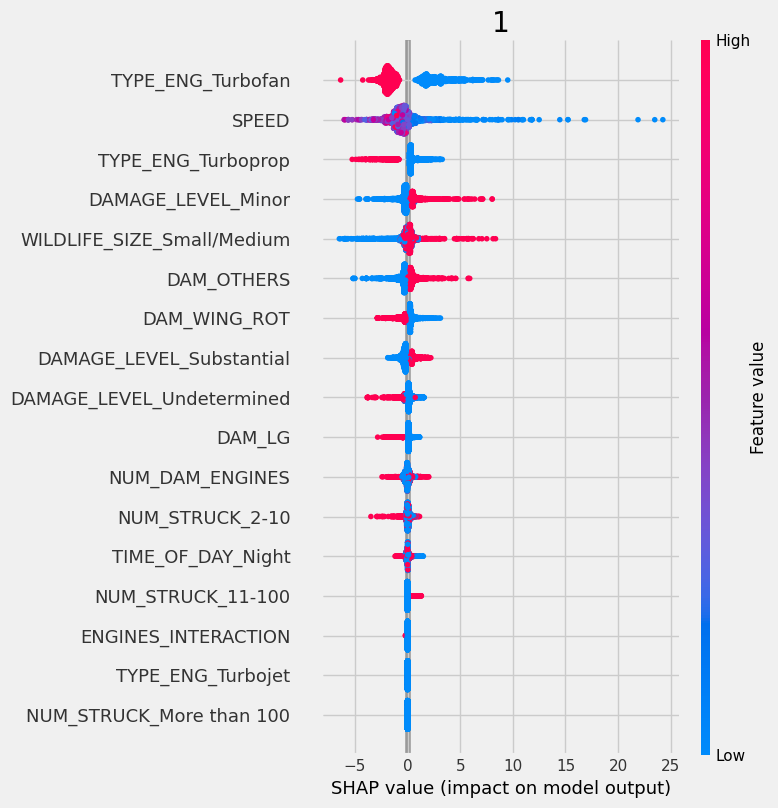

In [55]:
tlearnerl.plot_shap_values(X, t_itel, features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

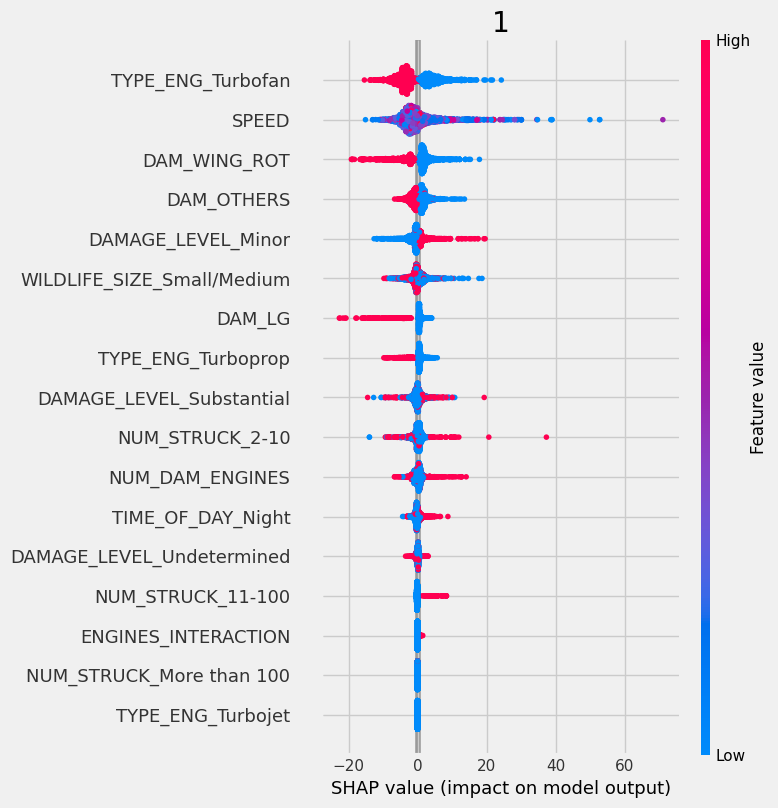

In [56]:
tlearnerx.plot_shap_values(X, t_itex, features=feature_names)

### X-learner

While both X and R learners are capable of handling heterogeneous treatment effects, the X-learner's methodology, which centers on imputing potential outcomes, is hypothesised to be more robust in the presence of the substantial imbalance between the control and treatment groups (2500+ vs. 300+ entries).  Thus, two X-learner models were developed and compared, utilising Random Forest and LightGBM regressors to investigate the impact of base learner selection.

In [87]:
# LGBM base learner
xlearnerl = BaseXRegressor(LGBMRegressor(random_state=5))
x_atel = xlearnerl.estimate_ate(X, T, Y)[0][0]
x_itel = xlearnerl.fit_predict(X, T, Y)

# Inverse log the calculated ATE because Y had undergone log transformation
x_atel = np.expm1(x_atel)
x_itel = np.expm1(x_itel)

# Linear regression base learner
xlearnerrf = BaseXRegressor(RandomForestRegressor(random_state=5))
x_aterf = xlearnerrf.estimate_ate(X, T, Y)[0][0]
x_iterf = xlearnerrf.fit_predict(X, T, Y)
x_aterf = np.expm1(x_aterf)
x_iterf = np.expm1(x_iterf)

print('Average treatment effect using LGBM X-learner:', x_atel)
print('Average treatment effect using RF X-learner:', x_aterf)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 2575, number of used features: 15
[LightGBM] [Info] Start training from score 9.951078
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 309, number of used features: 11
[LightGBM] [Info] Start training from score 10.415802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Despite the difference in magnitude, both X-learner models (using Random Forest and LightGBM base learners) estimated a negative ATE. This concordance in the direction of the treatment effect reinforces the finding that, after controlling for potential confounders, B-737 aircraft are associated with lower repair costs. The more pronounced effect observed with the Random Forest base learner may be attributable to its different approach to modeling complex relationships compared to gradient boosting.

In [59]:
xlearnerl.get_importance(X=X,
                        tau=x_itel,
                        normalize=True,
                        method='auto',
                        features=feature_names,
                        random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: SPEED                         0.329317
 WILDLIFE_SIZE_Small/Medium    0.138503
 DAM_OTHERS                    0.108833
 DAM_WING_ROT                  0.081677
 NUM_DAM_ENGINES               0.072351
 NUM_STRUCK_2-10               0.065852
 DAMAGE_LEVEL_Minor            0.056082
 TIME_OF_DAY_Night             0.055076
 DAMAGE_LEVEL_Undetermined     0.041418
 DAMAGE_LEVEL_Substantial      0.037534
 TYPE_ENG_Turbofan             0.007059
 DAM_LG                        0.003088
 TYPE_ENG_Turboprop            0.002003
 NUM_STRUCK_11-100             0.001187
 ENGINES_INTERACTION           0.000018
 NUM_STRUCK_More than 100      0.000000
 TYPE_ENG_Turbojet             0.000000
 dtype: float64}

In [60]:
xlearnerrf.get_importance(X=X,
                        tau=x_iterf,
                        normalize=True,
                        method='auto',
                        features=feature_names,
                        random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: SPEED                         0.371396
 DAM_OTHERS                    0.098805
 DAMAGE_LEVEL_Substantial      0.075490
 DAMAGE_LEVEL_Minor            0.070033
 WILDLIFE_SIZE_Small/Medium    0.069196
 NUM_STRUCK_11-100             0.061651
 DAMAGE_LEVEL_Undetermined     0.054856
 NUM_STRUCK_2-10               0.050180
 DAM_WING_ROT                  0.045443
 NUM_DAM_ENGINES               0.044904
 TIME_OF_DAY_Night             0.030438
 DAM_LG                        0.024025
 ENGINES_INTERACTION           0.001774
 TYPE_ENG_Turbofan             0.001603
 TYPE_ENG_Turboprop            0.000207
 NUM_STRUCK_More than 100      0.000000
 TYPE_ENG_Turbojet             0.000000
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

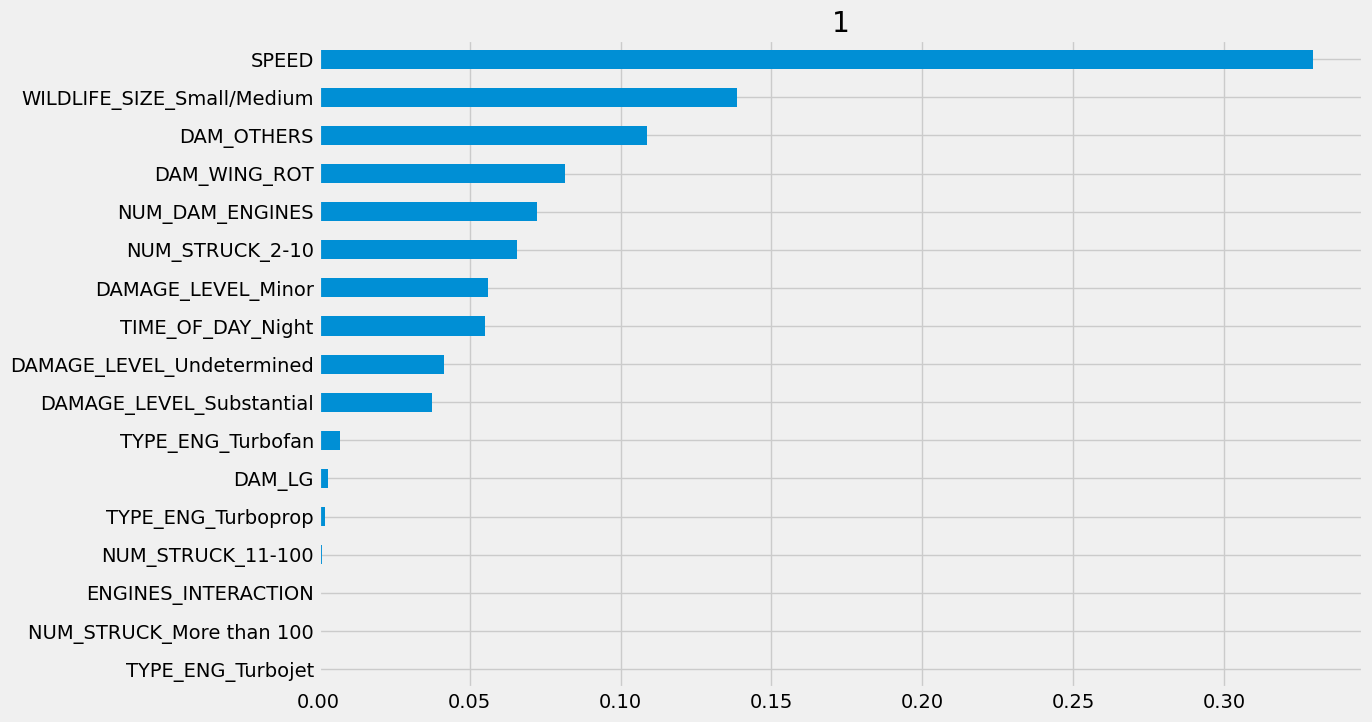

In [61]:
xlearnerl.plot_importance(X=X,
                         tau=x_itel,
                         normalize=True,
                         method='auto',
                         features=feature_names,
                         random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

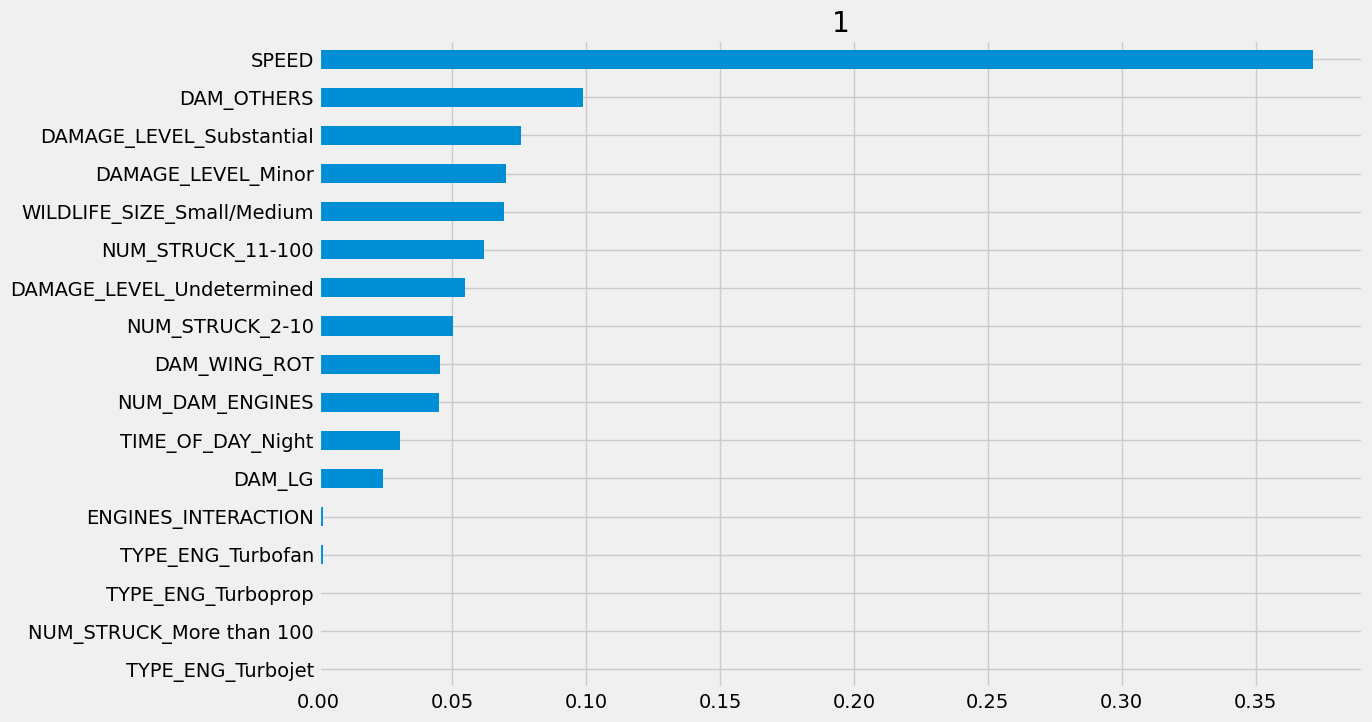

In [62]:
xlearnerrf.plot_importance(X=X,
                         tau=x_iterf,
                         normalize=True,
                         method='auto',
                         features=feature_names,
                         random_state=5)

While SPEED is the top feature in both, Random Forest emphasizes its importance more strongly (refer to 2nd plot directly above). The difference in the order and relative importance of mid-rank features also suggest that the two models capture different aspects of the data. RF, being an ensemble of decorrelated trees, might distribute importance more evenly across features reflected in the smaller difference in importance across features. Once again, there is also a difference in importance given to the nature of wildlife struck between the 2 base learners just like the case seen in the 2 different T-learners.

Now to compare differences in importance upon introducing train-test split.

In [67]:
start_time = time.time()
X_trainl, X_testl, y_trainl, y_testl = train_test_split(X, x_itel, test_size=0.2, shuffle=True, random_state=5)

model_tau_xl = model_tau.fit(X_trainl, y_trainl)

perm_imp_testl = permutation_importance(model_tau_xl,
                                       X_testl,
                                       y_testl,
                                       random_state=5).importances_mean

pd.Series(perm_imp_testl, index=feature_names).sort_values(ascending=False)
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 2307, number of used features: 15
[LightGBM] [Info] Start training from score 0.054366
--- 0.6891939640045166 seconds ---


In [68]:
start_time = time.time()
X_trainrf, X_testrf, y_trainrf, y_testrf = train_test_split(X, x_iterf, test_size=0.2, shuffle=True, random_state=5)

model_tau_xrf = model_tau.fit(X_trainrf, y_trainrf)

perm_imp_testrf = permutation_importance(model_tau_xrf,
                                       X_testrf,
                                       y_testrf,
                                       random_state=5).importances_mean

pd.Series(perm_imp_testrf, index=feature_names).sort_values(ascending=False)
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 2307, number of used features: 15
[LightGBM] [Info] Start training from score 0.226610
--- 0.6743192672729492 seconds ---


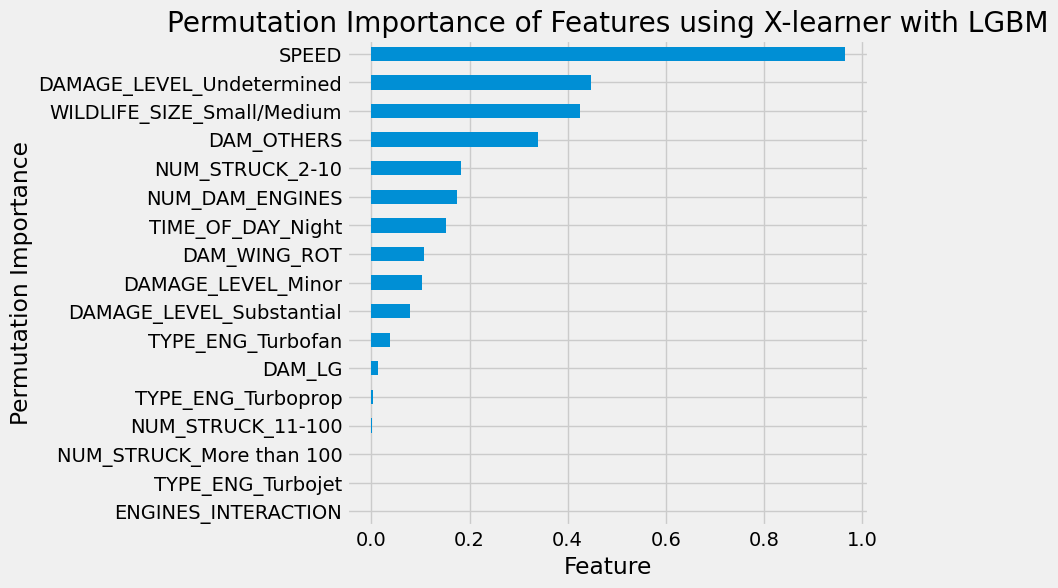

In [69]:
pd.Series(perm_imp_testl, index=feature_names).sort_values().plot(kind='barh', figsize=(6, 6))
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features using X-learner with LGBM')
plt.show()

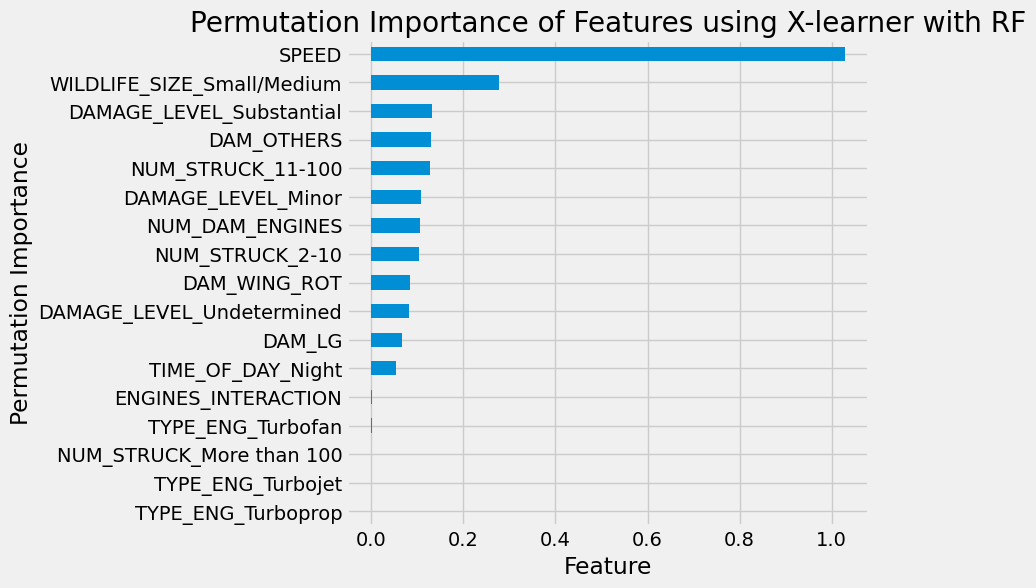

In [70]:
pd.Series(perm_imp_testrf, index=feature_names).sort_values().plot(kind='barh', figsize=(6, 6))
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features using X-learner with RF')
plt.show()

Again, SPEED remains the most important feature across all scenarios, suggesting its robust influence on the outcome. The relative importance of other features also changed just like in the case of the 2 T-learners, particularly in the mid-rank. This is likely due to the train-test split altering the data distribution and the models learning different relationships on the training subset. It is also worthy to note that though there are changes in rankings, both models have attributed higher relative importance to the size and quantity of wildlife, unlike that seen in the T-learners where the quantity was not given as much importance.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

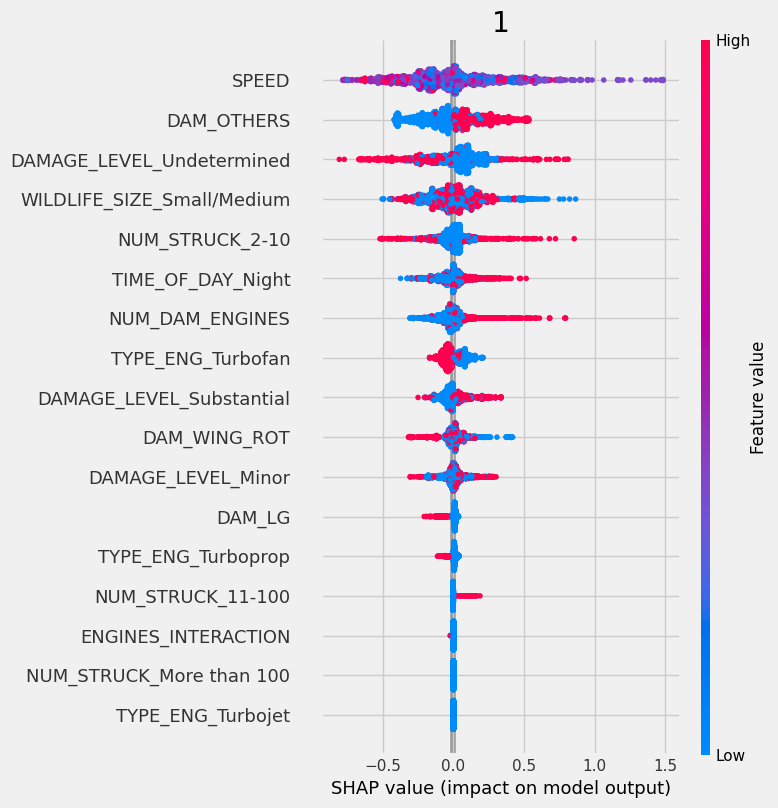

In [65]:
xlearnerl.plot_shap_values(X, x_itel, features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

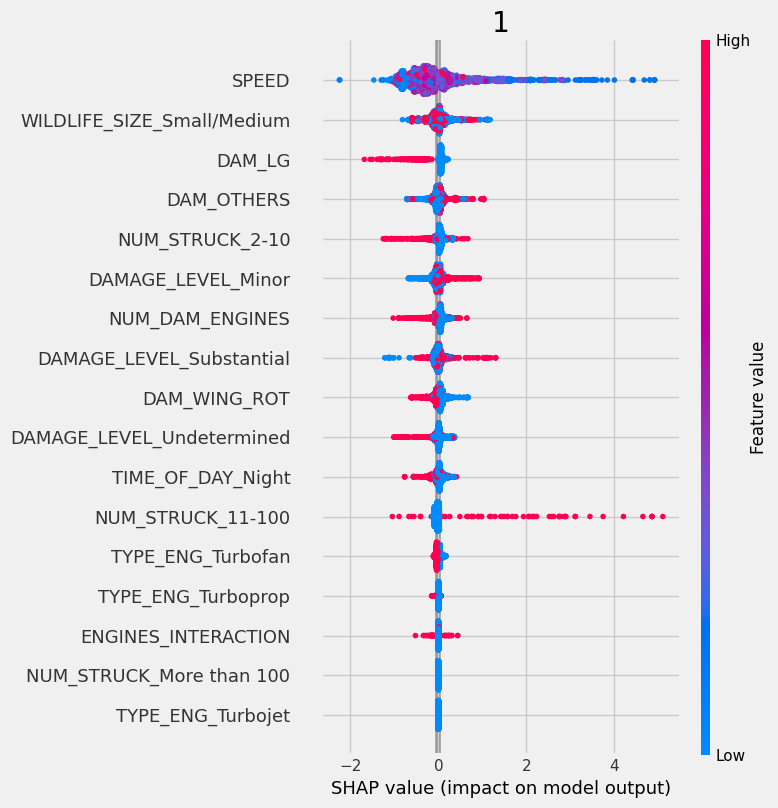

In [64]:
xlearnerrf.plot_shap_values(X, x_iterf, features=feature_names)

### R-learner

In [63]:
rlearner = BaseRRegressor(LGBMRegressor(random_state=5))
r_ate = rlearner.estimate_ate(X, T, Y)[0][0]
r_ite = rlearner.fit_predict(X, T, Y)

# Inverse log the calculated ATE because Y had undergone log transformation
r_ate = np.expm1(r_ate)
r_ite = np.expm1(r_ite)

print('Average treatment effect using LGBM R-learner:',r_ate)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 2884, number of used features: 15
[LightGBM] [Info] Start training from score -0.238855
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 2884, number of used features: 15
[LightGBM] [Info] Start training from score -0.241901
Average treatment effect using LGBM R-learner: -0.174276630798837


In [71]:
rlearner.get_importance(X=X,
                        tau=r_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names,
                        random_state=5)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: SPEED                         6.710015e-01
 DAM_WING_ROT                  8.516453e-02
 DAMAGE_LEVEL_Substantial      6.607971e-02
 TIME_OF_DAY_Night             6.201647e-02
 DAMAGE_LEVEL_Minor            2.591525e-02
 DAM_LG                        2.392462e-02
 NUM_DAM_ENGINES               1.740661e-02
 DAM_OTHERS                    1.265700e-02
 NUM_STRUCK_2-10               9.904499e-03
 TYPE_ENG_Turboprop            8.480147e-03
 WILDLIFE_SIZE_Small/Medium    6.211957e-03
 DAMAGE_LEVEL_Undetermined     6.161494e-03
 TYPE_ENG_Turbofan             5.076012e-03
 ENGINES_INTERACTION           2.063110e-07
 NUM_STRUCK_11-100             1.225731e-10
 NUM_STRUCK_More than 100      0.000000e+00
 TYPE_ENG_Turbojet             0.000000e+00
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

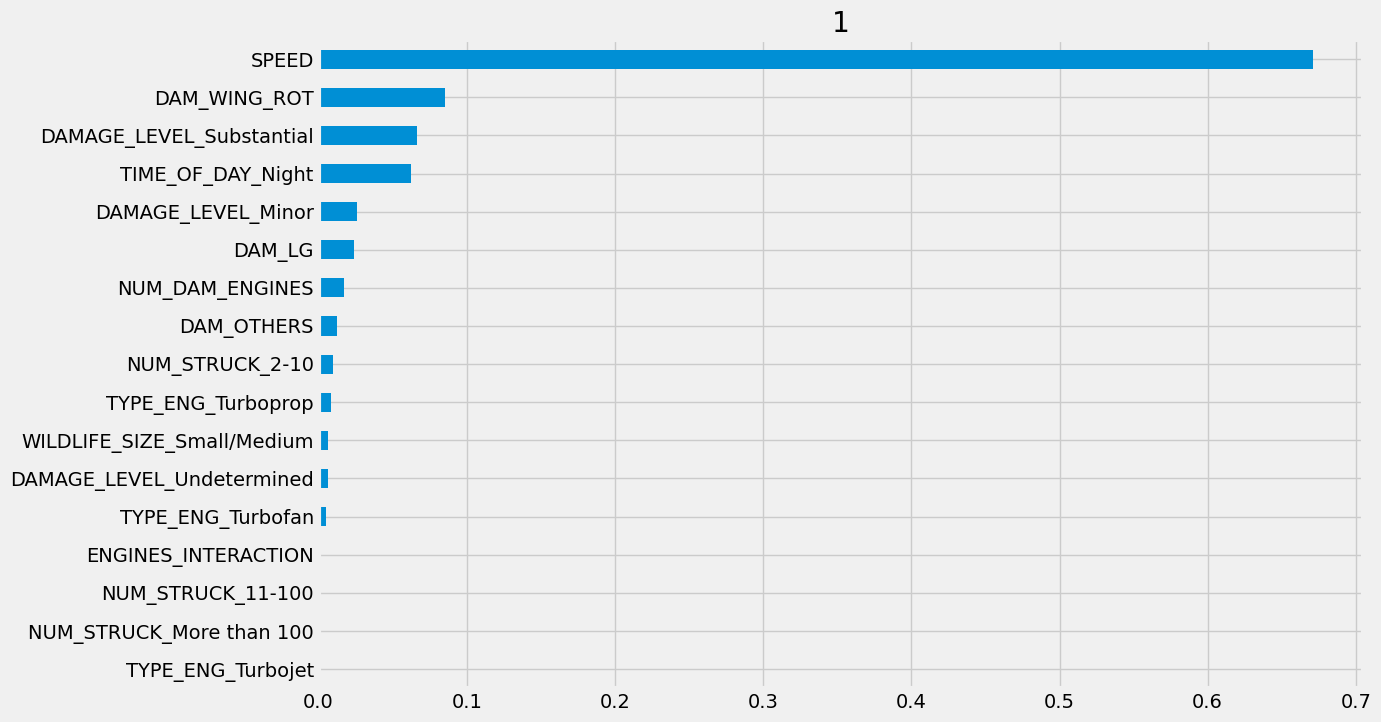

In [72]:
rlearner.plot_importance(X=X,
                         tau=r_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names,
                         random_state=5)

Interestingly, the R-learner uniquely identified time of day as a relatively important factor, while it was ranked lower by the other meta-learners. This distinction suggests that the R-learner might be capturing a nuanced relationship between time of day and wildlife strikes that the other models are missing. Given that visibility is typically reduced at night, the R-learner's emphasis on time of day aligns with the expectation that lower visibility could increase the risk of wildlife strikes. It may be noteworthy to further explore this factor in CATE to investigate if there are differences between the flights that occurred during different times of day.

In [73]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, r_ite, test_size=0.2, shuffle=True, random_state=5)

model_tau_r = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(model_tau_r,
                                       X_test,
                                       y_test,
                                       random_state=5).importances_mean

pd.Series(perm_imp_test, index=feature_names).sort_values(ascending=False)
print("--- %s seconds ---" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 2307, number of used features: 15
[LightGBM] [Info] Start training from score 613.424722
--- 0.81551194190979 seconds ---


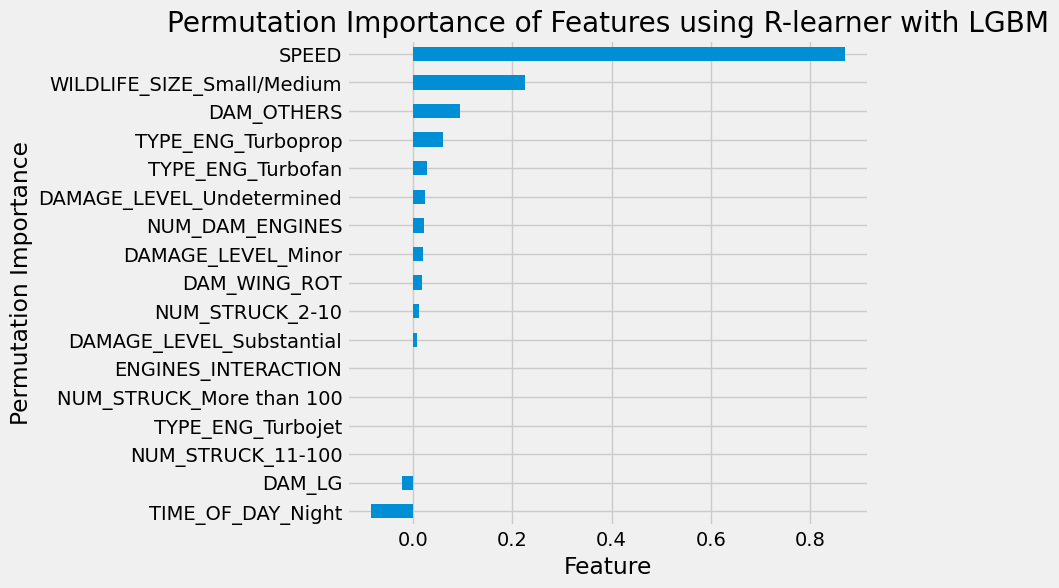

In [74]:
pd.Series(perm_imp_test, index=feature_names).sort_values().plot(kind='barh', figsize=(6, 6))
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance of Features using R-learner with LGBM')
plt.show()

 The most notable difference is the rise of WILDLIFE_SIZE_Small/Medium and DAM_OTHERS in the post-split plot, while DAM_WING_ROT and TIME_OF_DAY_Night decrease in importance. This suggests that the train-test split has altered the model's focus, likely due to changes in the data distribution. The significant drop in importance for TIME_OF_DAY_Night after the split is particularly interesting. It suggests that this feature's importance might have been partly due to characteristics specific to the full dataset. Further analysis on CATE will be conducted according to time of day to investigate this factor.

 That aside, SPEED has emerged top again which further reinforces the likelihood that it has an impact on the repair cost of aircrafts.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

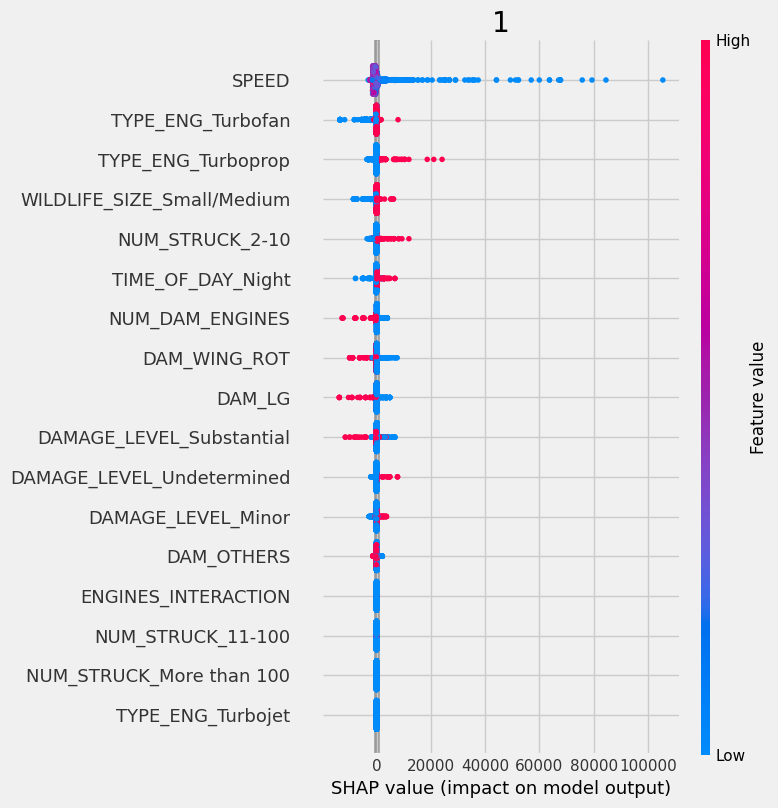

In [75]:
rlearner.plot_shap_values(X, r_ite, features=feature_names)

In [86]:
print('Comparison of ATE across all meta-learners')
print('ATE with S-learner:', s_ate)
print('ATE with T-learner (LGBM):', t_atel)
print('ATE with T-learner (XGB):', t_atex)
print('ATE with X-learner (LGBM):', x_atel)
print('ATE with X-learner (RF):', x_aterf)
print('ATE with R-learner:', r_ate)

Comparison of ATE across all meta-learners
ATE with S-learner: -0.12644847686449534
ATE with T-learner (LGBM): 0.33398570436512665
ATE with T-learner (XGB): -0.03854324056464561
ATE with X-learner (LGBM): -0.17628730377998847
ATE with X-learner (RF): -0.25803241713194053
ATE with R-learner: -0.174276630798837


**Overall ATE Discussion**

From the ATE gathered across the different meta learners, it is evident that the negative ATEs dominate, suggesting that on average, using B-737 aircraft is associated with *lower* repair costs.

The T-learner with LGBM as the base learner stands out with a positive ATE (0.334). This is a significant discrepancy compared to all other models, which estimate negative ATEs. This strongly suggests a problem with this specific model. As T-learners are known to be sensitive to model misspecifications, the LGBM models for the treated and control groups might not be accurately capturing the relationships between features and repair costs, making predictions for individuals far outside the range of the observed data, especially with the existing class imbalance. To assess which model provides the most accurate and reliable ATE estimates, other metrics would be necessary. However, it is heartening to see that the models generally agree on the direction of the effect.

#### **CATE**

CATE analysis in this section will be done using X-learner with LGBM as its base learner.

In [173]:
# For math check
#x_atel = xlearnerl.estimate_ate(X, T, Y)[0][0]  # Direct ATE estimate
#x_itel = xlearnerl.fit_predict(X, T, Y)        # Individual Treatment Effects (ITEs)
#x_itel_mean = x_itel.mean()                    # Mean of ITEs

#print(f"ATE from estimate_ate(): {x_atel}")
#print(f"Mean of ITEs: {x_itel_mean}")
#print(f"Difference: {x_atel - x_itel_mean}")

#log_value = -0.19393347950796422
#inverse_log_value = np.expm1(log_value)
#print(f"{inverse_log_value=}")

ATE from estimate_ate(): -0.19393347950796422
Mean of ITEs: -0.19393347950796422
Difference: 0.0


In [115]:
time_groups = X['cat__TIME_OF_DAY_Night'].unique() # get unique time categories
cate_time = {}

for t in time_groups:
  group_mask = X['cat__TIME_OF_DAY_Night'] == t # create mask for each time group
  cate = np.mean(x_itel[group_mask]) # compute mean ITE for each group
  cate_time[t] = np.expm1(cate)

# Convert dictionary to df
cate_time_df = pd.DataFrame.from_dict(cate_time, orient='index', columns=['CATE'])
cate_time_df.index.name = 'Time of Day (Night)'
cate_time_df.reset_index(inplace=True)
cate_time_df

,Time of Day (Night),CATE
0,0.0,-0.153779
1,1.0,-0.215768


In [122]:
num_engs = X['remainder__NUM_DAM_ENGINES'].unique() # get unique categories for number of engines
cate_eng_no = {}

for t in num_engs:
  group_mask = X['remainder__NUM_DAM_ENGINES'] == t # create mask for each eng num group
  cate = np.mean(x_itel[group_mask]) # compute mean ITE for each group
  cate_eng_no[t] = np.expm1(cate)

# Convert dictionary to df
cate_eng_no_df = pd.DataFrame.from_dict(cate_eng_no, orient='index', columns=['CATE'])
cate_eng_no_df.index.name = 'Number of Damaged Engines'
cate_eng_no_df.reset_index(inplace=True)
cate_eng_no_df

,Number of Damaged Engines,CATE
0,1.0,-0.104976
1,2.0,-0.146163
2,0.0,-0.203850


In [120]:
eng_type_columns = ['cat__TYPE_ENG_Turbofan', 'cat__TYPE_ENG_Turbojet', 'cat__TYPE_ENG_Turboprop']

for e in eng_type_columns:
    eng_type_mask = X[e] == 1

cate_eng_type = {}  # Dictionary to store CATE for each engine type

for e in eng_type_columns:
    eng_type_mask = X[e] == 1  # Create mask for each engine group
    cate = np.mean(x_itel[eng_type_mask])  # Compute mean ITE for each group
    cate_eng_type[e] = np.expm1(cate)  # Inverse log transformation after mean

# Convert to DataFrame for better readability
cate_eng_type_df = pd.DataFrame.from_dict(cate_eng_type, orient='index', columns=['CATE'])
cate_eng_type_df.index.name = 'Type of aircraft engine'
cate_eng_type_df.reset_index(inplace=True)
cate_eng_type_df

,Type of aircraft engine,CATE
0,cat__TYPE_ENG_Turbofan,-0.243463
1,cat__TYPE_ENG_Turbojet,0.007923
2,cat__TYPE_ENG_Turboprop,-0.116118


In [123]:
num_struck_columns = ['cat__NUM_STRUCK_11-100', 'cat__NUM_STRUCK_2-10', 'cat__NUM_STRUCK_More than 100']
cate_num_struck = {}  # Dictionary to store CATE per wildlife strike group

for num_struck in num_struck_columns:
    num_struck_mask = X[num_struck] == 1  # Create mask for each strike group
    cate = np.mean(x_itel[num_struck_mask])  # Compute mean ITE for each group
    cate_num_struck[num_struck] = np.expm1(cate)  # Inverse log transformation after mean

# Convert to DataFrame for better readability
cate_num_struck_df = pd.DataFrame.from_dict(cate_num_struck, orient='index', columns=['CATE'])
cate_num_struck_df.index.name = 'Number of Wildlife Struck'
cate_num_struck_df.reset_index(inplace=True)
cate_num_struck_df

,Number of Wildlife Struck,CATE
0,cat__NUM_STRUCK_11-100,0.109622
1,cat__NUM_STRUCK_2-10,-0.164360
2,cat__NUM_STRUCK_More than 100,0.096786


### **CATE Discussions**

The X-learner with LGBM base learner was utilised for CATE analysis. For reference purposes, ATE was -0.176.

Looking at the CATE for **Time of Day**, negative CATE values across both groups suggest that using the Boeing 737 (treatment group) tends to reduce repair costs compared to other aircraft types, regardless of the time of day. Larger cost reduction at night (-0.2158 vs. -0.1538 during the day) suggests that the treatment effect is stronger at night, meaning that B-737 aircraft experience even lower repair costs after wildlife strikes at night compared to daytime. This was interesting because the cost reduction was more pronounced for night strikes -- I had expected the reverse to be true with lower visibility. But perhaps this observation was attributed to less congestion in the air, thus giving the aircrafts more allowance to manouveur away from wildlife during their flight. If the pattern holds across other variables, airlines may consider favoring B-737s for nighttime operations due to cost efficiency in post-strike repairs.


---


When considering the **number of damaged engines**, negative CATE was again observed across all groups, indicating that repair costs are lower for B-737 irrespective of number of damaged engines. This is likely attributed to greater availability of mechanical parts for the plane considering the ubiquity in its usage worldwide.



---

Judging from the CATE values for different engine types, turbofan engines seem to have the strongest negative treatment effect, indicating that they are more cost-effective for repair after wildlife strikes on the Boeing 737. Turboprop engines also show a negative treatment effect, though it is weaker than that of turbofan engines. Turbojet engines, however, appear to have a negligible impact on repair costs, with a slight positive effect.

If the goal is to reduce repair costs related to wildlife strikes, then turbofan engines may be the preferred choice for the Boeing 737, as they show a larger reduction in repair costs. Turboprop engines could also be a good option, though the cost savings are less significant than with turbofan engines.
Turbojet engines, given their negligible effect, might be less favorable from a cost-reduction standpoint, suggesting that turbofan or turboprop engines would likely be more effective in controlling repair costs.

---


Considering the **number of wildlife struck**, CATE values are mixed, indicating that the treatment effect (Boeing 737) on repair costs varies depending on the number of wildlife struck.

For the 11-100 and more than 100 wildlife struck group, the CATE is positive, suggesting that when there are the strike involves a relatively big group of wildlife, Boeing 737 aircraft tends to increase repair costs compared to other aircraft types. But when the group is smaller, the repair cost is cheaper. This is reasonable considering that larger strike volumes (11-100 or more than 100) could lead to more significant or more widespread damage, which might be less influenced by the type of aircraft used, potentially increasing costs similarly across aircraft types.

Lower strike volumes (2-10) might lead to smaller or more manageable damages where the Boeing 737 may be better equipped to handle repairs at a lower cost. From airline perspective, they can consider B-737 for routes or areas with less congregation of wildlife (need to look into wildlife migration patterns or the wildlife that inhabit the airport vicinity). As for routes or areas more prone to frequent strikes, the Boeing 737 may not offer significant cost savings and could result in higher repair costs, suggesting that other aircraft types may be more appropriate in these scenarios.

### **DoWhy Analysis**

In [156]:
# Convert Y and T into df
Y_df = pd.DataFrame(Y, columns=['log1p_COST_REPAIRS_INFL_ADJ'])
T_df = pd.DataFrame(T, columns=['Treatment'])

# Concatenate X, Y, T into a single df
dowhy_df = pd.concat([X, Y_df, T_df], axis=1)
dowhy_df.head()

causes = [col for col in dowhy_df.columns if col not in ['log1p_COST_REPAIRS_INFL_ADJ', 'Treatment']]

In [157]:
model = CausalModel(
    data=dowhy_df,
    treatment = ['Treatment'],
    outcome = ['log1p_COST_REPAIRS_INFL_ADJ'],
    common_causes = causes
)

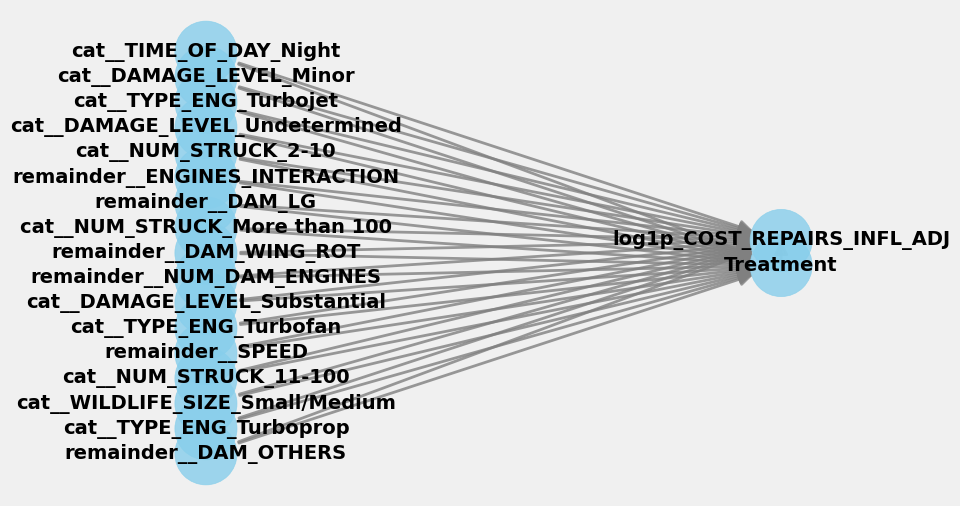

In [163]:
model.view_model()

In [159]:
# Identify causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)

print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                             ↪
────────────(E[log1p_COST_REPAIRS_INFL_ADJ|remainder_OTHERS,cat_ENG_Turboprop,cat_LEVEL_Minor,cat_ ↪
d[Treatment]                                                                                       ↪

↪                                                                                                  ↪
↪ SIZE_Small/Medium,cat_STRUCK_11-100,remainder_STRUCK_2-10,cat_ENG_Turbofan,remainder_DAM_ENGINES ↪
↪                                                                                                  ↪

↪                                                                                                  ↪
↪ ,remainder_LG,cat_STRUCK_More than 100,remainder_INTERACTION,cat_ENG_Turbojet,cat_LEVEL_Undeterm ↪
↪                                                                                

In [172]:
# Estimate the causal effect
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

# Inverse log transformation of the estimate value
inverse_log_estimate = np.expm1(estimate.value)

# Print the components and inverse log estimate
print(estimate)
print(f"Inverse Log Estimate: {inverse_log_estimate}")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                             ↪
────────────(E[log1p_COST_REPAIRS_INFL_ADJ|remainder_OTHERS,cat_ENG_Turboprop,cat_LEVEL_Minor,cat_ ↪
d[Treatment]                                                                                       ↪

↪                                                                                                  ↪
↪ SIZE_Small/Medium,cat_STRUCK_11-100,remainder_STRUCK_2-10,cat_ENG_Turbofan,remainder_DAM_ENGINES ↪
↪                                                                                                  ↪

↪                                                                                                  ↪
↪ ,remainder_LG,cat_STRUCK_More than 100,remainder_INTERACTION,cat_ENG_Turbojet,cat_LEVEL_Undeterm ↪
↪                                

In [174]:
# Causal effect on the control group
causal_estimate_att = model.estimate_effect(identified_estimand,
                                            method_name = "backdoor.propensity_score_matching",
                                            target_units = "atc")

print(causal_estimate_att)
print(f"Inverse Log Estimate: {np.expm1(causal_estimate_att.value)}")
# Positive = treatment increases cost for control group

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                             ↪
────────────(E[log1p_COST_REPAIRS_INFL_ADJ|remainder_OTHERS,cat_ENG_Turboprop,cat_LEVEL_Minor,cat_ ↪
d[Treatment]                                                                                       ↪

↪                                                                                                  ↪
↪ SIZE_Small/Medium,cat_STRUCK_11-100,remainder_STRUCK_2-10,cat_ENG_Turbofan,remainder_DAM_ENGINES ↪
↪                                                                                                  ↪

↪                                                                                                  ↪
↪ ,remainder_LG,cat_STRUCK_More than 100,remainder_INTERACTION,cat_ENG_Turbojet,cat_LEVEL_Undeterm ↪
↪                                

In [186]:
# Refute the estimate - checks how sensitive causal estimate is to potential violations of the assumptions
refute_results = model.refute_estimate(identified_estimand,
                                       estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:1.8748666934925842
New effect:0.006394881640269266
p value:0.9199999999999999



### Final Discussion

Based on the DoWhy analysis, it was found that, on average, the treatment (use of the B-737 aircraft) increases the repair cost by approximately 5.52 units (post inverse log transformation), after controlling for confounders. This result contradicts my initial hypothesis, which posits that the B-737 treatment would lower repair costs.

On the other hand, the meta-learners yielded negative average treatment effect (ATE) estimates, suggesting that the B-737 aircraft reduces repair costs. This disparity between the DoWhy and meta-learner results raises important questions regarding the validity and robustness of the estimates. Since the meta-learners do not explicitly control for confounders in the same way DoWhy does, they may have overlooked confounding factors, leading to a biased conclusion that the B-737 reduces repair costs.

To test the robustness of the ATE estimate obtained from DoWhy, I applied a placebo treatment refuter. The placebo refuter simulates a situation where the treatment (B-737) has no real effect on the outcome (repair costs) and helps assess whether the observed effect could have occurred purely by chance.

The placebo treatment refuter results indicated almost no effect (0.0063) with a high p-value of 0.92, suggesting that in the absence of a true causal relationship, the observed effect is unlikely to be meaningful. This casts doubt on the original estimate from DoWhy, which suggested an increase in repair costs due to the B-737.

In light of these findings, I acknowledge that there may be additional, unaccounted factors influencing repair costs that were not captured in the analysis. These could include operational factors specific to the B-737 aircraft, maintenance practices, or broader industry trends. Thus, while both approaches offer valuable insights, further investigation and is needed to refine the model and test the hypothesis more robustly. Until then, the hypothesis remains inconclusive.